In [1]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
from catboost import CatBoostClassifier, Pool
from sklearn import metrics
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)
from sklearn.model_selection import (
    KFold,
    RandomizedSearchCV,
    StratifiedKFold,
    cross_val_score,
    train_test_split,
)
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
import shap

warnings.filterwarnings("ignore", category=FutureWarning)
pd.options.display.max_columns = 500
plt.style.use("fast")

In [2]:
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")
full_train = train_df.drop(["id"], axis=1)
test_df = test_df.drop(["id"], axis=1)
full_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140700 entries, 0 to 140699
Data columns (total 19 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   Name                                   140700 non-null  object 
 1   Gender                                 140700 non-null  object 
 2   Age                                    140700 non-null  float64
 3   City                                   140700 non-null  object 
 4   Working Professional or Student        140700 non-null  object 
 5   Profession                             104070 non-null  object 
 6   Academic Pressure                      27897 non-null   float64
 7   Work Pressure                          112782 non-null  float64
 8   CGPA                                   27898 non-null   float64
 9   Study Satisfaction                     27897 non-null   float64
 10  Job Satisfaction                       112790 non-null  

In [3]:
full_train.describe().round(2).style.format(precision=2).background_gradient(
    cmap="Blues"
)

In [4]:
full_train.describe(include="object")

Name  Gender    City Working Professional or Student Profession  \
count   140700  140700  140700                          140700     104070   
unique     422       2      98                               2         64   
top      Rohan    Male  Kalyan            Working Professional    Teacher   
freq      3178   77464    6591                          112799      24906   

           Sleep Duration Dietary Habits    Degree  \
count              140700         140696    140698   
unique                 36             23       115   
top     Less than 5 hours       Moderate  Class 12   
freq                38784          49705     14729   

       Have you ever had suicidal thoughts ? Family History of Mental Illness  
count                                 140700                           140700  
unique                                     2                                2  
top                                       No                               No  
freq                                   71138                            70758

In [5]:
def new_feats(df):
    df = (
        df.assign(satisfaction_by_work=df["Work Pressure"] / df["Job Satisfaction"])
        .assign(
            satisfaction_by_study=df["Academic Pressure"] / df["Study Satisfaction"]
        )
        .assign(age_work_satisfaction=df["Age"] / df["Job Satisfaction"])
        .assign(cgpa_study=df["CGPA"] / df["Academic Pressure"])
    )
    return df

In [6]:
full_train = new_feats(full_train).copy()
test_df = new_feats(test_df).copy()
print("*************************************")
print("----------full_train Shape------------")
print(full_train.shape)
print("*************************************")
print("----------test_df Shape------------")
print(test_df.shape)
print("*************************************")

*************************************
----------full_train Shape------------
(140700, 23)
*************************************
----------test_df Shape------------
(93800, 22)
*************************************


In [7]:
num_feats = full_train.select_dtypes(include="float64").columns
obj_feats = full_train.select_dtypes(include="object").columns
target = full_train.select_dtypes(include="int64").columns
print("*************************************")
print("----------Numerical Featuers---------")
print(num_feats)
print("*************************************")
print("----------Object Featuers------------")
print(obj_feats)
print("*************************************")
print("----------Target Variable------------")
print(target)
print("*************************************")

*************************************
----------Numerical Featuers---------
Index(['Age', 'Academic Pressure', 'Work Pressure', 'CGPA',
       'Study Satisfaction', 'Job Satisfaction', 'Work/Study Hours',
       'Financial Stress', 'satisfaction_by_work', 'satisfaction_by_study',
       'age_work_satisfaction', 'cgpa_study'],
      dtype='object')
*************************************
----------Object Featuers------------
Index(['Name', 'Gender', 'City', 'Working Professional or Student',
       'Profession', 'Sleep Duration', 'Dietary Habits', 'Degree',
       'Have you ever had suicidal thoughts ?',
       'Family History of Mental Illness'],
      dtype='object')
*************************************
----------Target Variable------------
Index(['Depression'], dtype='object')
*************************************


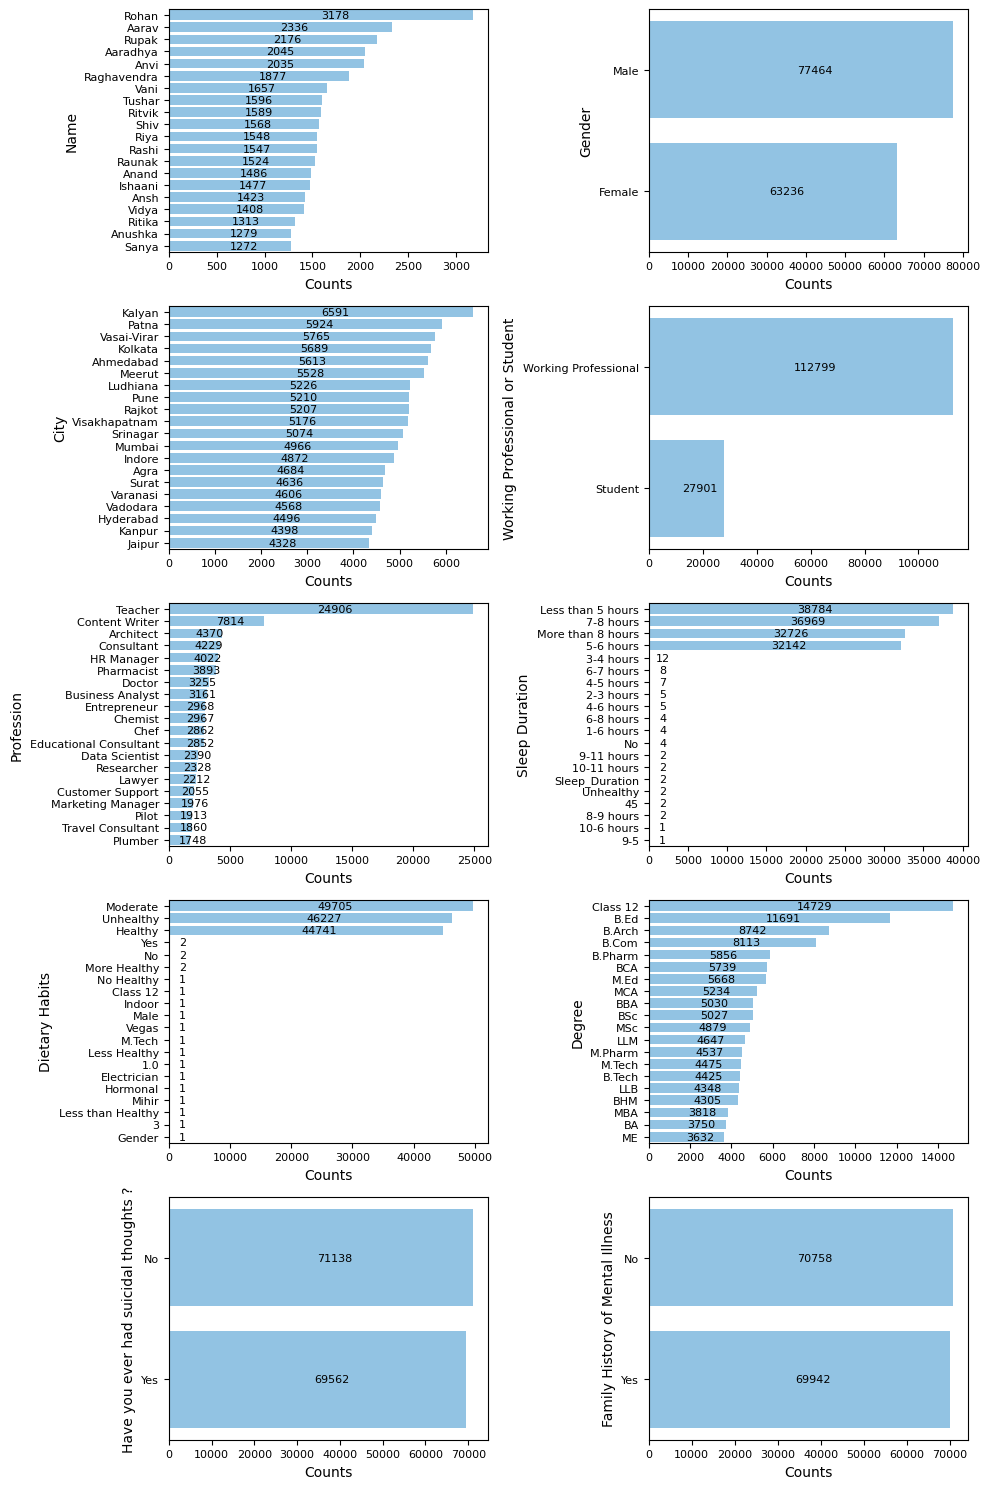

In [8]:
fig = plt.figure(figsize=(10, 15))

for i, feature in enumerate(obj_feats):
    ax = fig.add_subplot(5, 2, i + 1)
    df_temp = full_train[feature].value_counts().nlargest(20).reset_index()
    sns.barplot(df_temp, y=feature, x="count", color="#66b7ee", orient="h", alpha=0.8)
    ax.bar_label(
        ax.containers[0], label_type="center", padding=10, color="black", fontsize=8
    )
    ax.set_ylabel(feature, fontsize=10)
    ax.set_xlabel("Counts", fontsize=10)
    ax.tick_params(axis="both", labelsize=8)


fig.tight_layout()
plt.show()

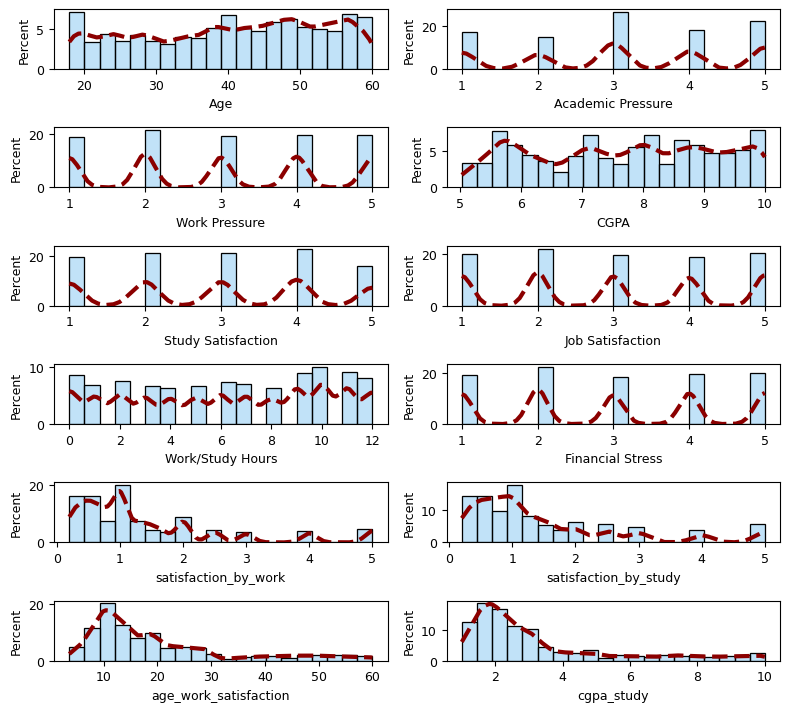

In [9]:
fig = plt.figure(figsize=(8, 8))

for i, feature in enumerate(num_feats):
    ax = fig.add_subplot(7, 2, i + 1)
    sns.histplot(
        full_train[feature],
        stat="percent",
        kde=True,
        bins=20,
        alpha=0.4,
        color="#66b7ee",
        line_kws={"lw": 3, "linestyle": "dashed"},
    ).lines[0].set_color("darkred")
    plt.tick_params(axis="both", labelsize=9)
    plt.ylabel("Percent", fontsize=9)
    plt.xlabel(feature, fontsize=9)


fig.tight_layout()
plt.show()

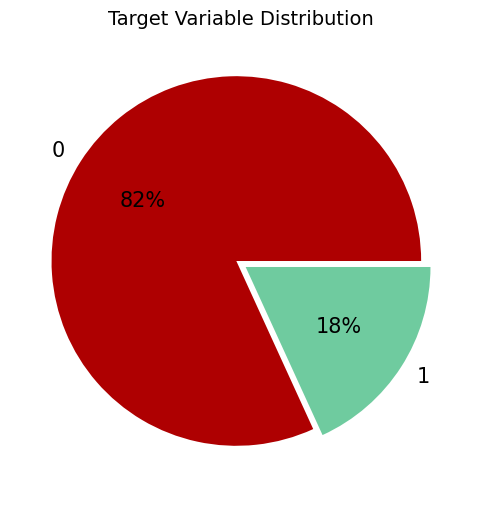

In [10]:
target_colors = [
    "#ae0001",
    "#6fcb9f",
]
plt.figure(figsize=(6, 6))
plt.pie(
    full_train["Depression"].value_counts(),
    labels=full_train["Depression"].value_counts().index,
    textprops={"fontsize": 15, "color": "black"},
    colors=target_colors,
    autopct="%.0f%%",
    explode=[0.03, 0.03],
)
plt.title("Target Variable Distribution", fontsize=14)
plt.show()

In [11]:
## Feature Transform

In [12]:
deg = full_train["Degree"].value_counts()[0:27].reset_index()["Degree"].to_list()
full_train["Degree"] = np.where(full_train["Degree"].isin(deg), full_train["Degree"], "Other")
test_df["Degree"] = np.where(test_df["Degree"].isin(deg), test_df["Degree"], "Other")
print("****************************")
print("----------full_train--------")
print(full_train["Degree"].value_counts())
print("****************************")
print("----------test_df-----------")
print(test_df["Degree"].value_counts())
print("****************************")

****************************
----------full_train--------
Degree
Class 12    14729
B.Ed        11691
B.Arch       8742
B.Com        8113
B.Pharm      5856
BCA          5739
M.Ed         5668
MCA          5234
BBA          5030
BSc          5027
MSc          4879
LLM          4647
M.Pharm      4537
M.Tech       4475
B.Tech       4425
LLB          4348
BHM          4305
MBA          3818
BA           3750
ME           3632
MD           3383
MHM          3286
BE           3104
PhD          3103
M.Com        3094
MBBS         3082
MA           2887
Other         116
Name: count, dtype: int64
****************************
----------test_df-----------
Degree
Class 12    9812
B.Ed        7762
B.Arch      6037
B.Com       5439
B.Pharm     3987
BCA         3869
M.Ed        3707
MCA         3438
BBA         3387
BSc         3314
LLM         3133
MSc         3096
M.Tech      3017
M.Pharm     2995
LLB         2938
B.Tech      2885
BHM         2776
BA          2490
MBA         2470
ME          2391


In [13]:
def catplt(x_var, y_var, aspect = 4):
    gs = sns.catplot(
        data=full_train,
        x=x_var,
        y=y_var,
        kind="count",
        hue="Depression",
        #col=x_var,
        height=2,
        aspect=aspect,
        sharey=False,
        #col_wrap=2,
        palette=target_colors,
        legend_out=False,
        legend="auto",
        width=0.5,
    )
    for ax in gs.axes.ravel():
        for i in ax.containers:
            ax.bar_label(i, label_type="edge", fontsize=8)
            ax.set_xlabel("", fontsize=12)
            ax.set_ylabel("", fontsize=12)
            ax.tick_params(axis="both", labelsize=8)
            gs._legend.remove()
            gs.set_titles(size=8)

    plt.legend(title="Target", title_fontsize=8, fontsize=8, loc="best")
    plt.show()

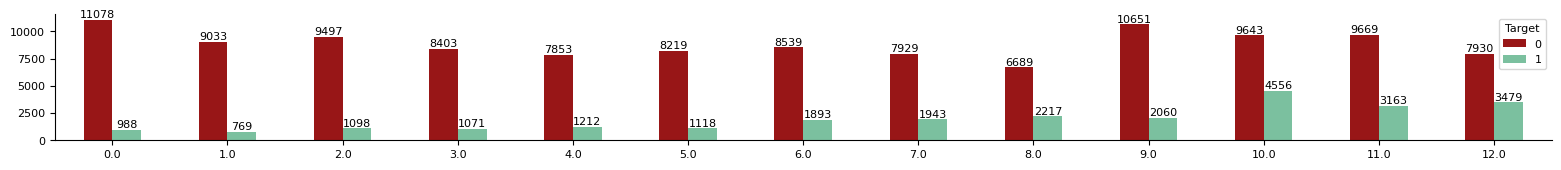

In [14]:
catplt(x_var="Work/Study Hours", y_var=None, aspect= 8)

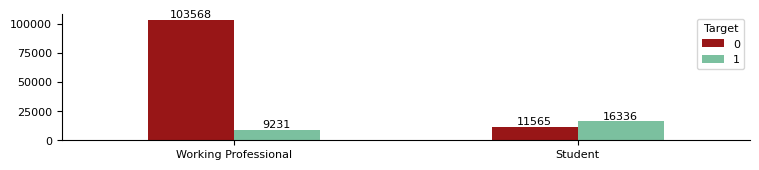

In [15]:
catplt(x_var="Working Professional or Student", y_var=None)

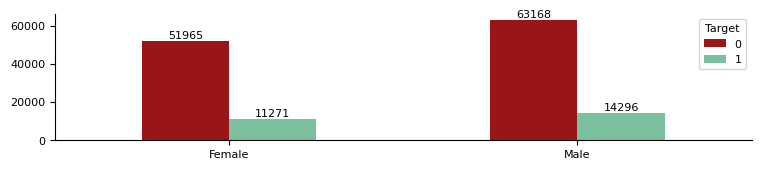

In [16]:
catplt(x_var="Gender", y_var=None)

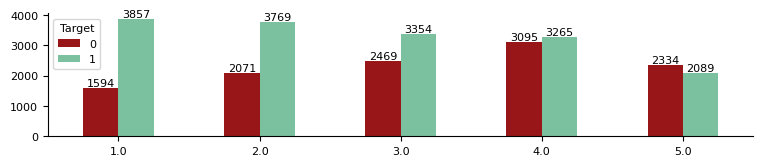

In [17]:
catplt(x_var="Study Satisfaction", y_var=None)

In [18]:
full_train["Degree"].value_counts(normalize=True)

Degree
Class 12    0.104684
B.Ed        0.083092
B.Arch      0.062132
B.Com       0.057662
B.Pharm     0.041620
BCA         0.040789
M.Ed        0.040284
MCA         0.037200
BBA         0.035750
BSc         0.035729
MSc         0.034677
LLM         0.033028
M.Pharm     0.032246
M.Tech      0.031805
B.Tech      0.031450
LLB         0.030903
BHM         0.030597
MBA         0.027136
BA          0.026652
ME          0.025814
MD          0.024044
MHM         0.023355
BE          0.022061
PhD         0.022054
M.Com       0.021990
MBBS        0.021905
MA          0.020519
Other       0.000824
Name: proportion, dtype: float64

In [19]:
deg = full_train["Degree"].value_counts()[0:27].reset_index()["Degree"].to_list()
full_train["Degree"] = np.where(full_train["Degree"].isin(deg), full_train["Degree"], "Other")
test_df["Degree"] = np.where(test_df["Degree"].isin(deg), test_df["Degree"], "Other")
print("****************************")
print("----------full_train--------")
print(full_train["Degree"].value_counts())
print("****************************")
print("----------test_df-----------")
print(test_df["Degree"].value_counts())
print("****************************")

****************************
----------full_train--------
Degree
Class 12    14729
B.Ed        11691
B.Arch       8742
B.Com        8113
B.Pharm      5856
BCA          5739
M.Ed         5668
MCA          5234
BBA          5030
BSc          5027
MSc          4879
LLM          4647
M.Pharm      4537
M.Tech       4475
B.Tech       4425
LLB          4348
BHM          4305
MBA          3818
BA           3750
ME           3632
MD           3383
MHM          3286
BE           3104
PhD          3103
M.Com        3094
MBBS         3082
MA           2887
Other         116
Name: count, dtype: int64
****************************
----------test_df-----------
Degree
Class 12    9812
B.Ed        7762
B.Arch      6037
B.Com       5439
B.Pharm     3987
BCA         3869
M.Ed        3707
MCA         3438
BBA         3387
BSc         3314
LLM         3133
MSc         3096
M.Tech      3017
M.Pharm     2995
LLB         2938
B.Tech      2885
BHM         2776
BA          2490
MBA         2470
ME          2391


In [20]:
dh = full_train["Dietary Habits"].value_counts()[0:3].reset_index()["Dietary Habits"].to_list()
full_train["Dietary Habits"] = np.where(full_train["Dietary Habits"].isin(dh), full_train["Dietary Habits"], "Moderate")
test_df["Dietary Habits"] = np.where(test_df["Dietary Habits"].isin(dh), test_df["Dietary Habits"], "Moderate")
print("****************************")
print("----------full_train---------")
print(full_train["Dietary Habits"].value_counts())
print("****************************")
print("----------test_df------------")
print(test_df["Dietary Habits"].value_counts())
print("****************************")

****************************
----------full_train---------
Dietary Habits
Moderate     49732
Unhealthy    46227
Healthy      44741
Name: count, dtype: int64
****************************
----------test_df------------
Dietary Habits
Moderate     33048
Unhealthy    30786
Healthy      29966
Name: count, dtype: int64
****************************


In [21]:
sleep_d =full_train["Sleep Duration"].value_counts()[0:4].reset_index()["Sleep Duration"].to_list()
full_train["Sleep Duration"] = np.where(full_train["Sleep Duration"].isin(sleep_d), full_train["Sleep Duration"], "1-8")
test_df["Sleep Duration"] = np.where(test_df["Sleep Duration"].isin(sleep_d), test_df["Sleep Duration"], "1-8")
print("****************************")
print("----------full_train---------")
print(full_train["Sleep Duration"].value_counts())
print("****************************")
print("----------test_df------------")
print(test_df["Sleep Duration"].value_counts())
print("****************************")

****************************
----------full_train---------
Sleep Duration
Less than 5 hours    38784
7-8 hours            36969
More than 8 hours    32726
5-6 hours            32142
1-8                     79
Name: count, dtype: int64
****************************
----------test_df------------
Sleep Duration
Less than 5 hours    25661
7-8 hours            24491
More than 8 hours    22190
5-6 hours            21404
1-8                     54
Name: count, dtype: int64
****************************


2.    El autor podría considerar que las categorías más frecuentes después de la principal ([1:35]) son más representativas de la diversidad en la variable Profession.
    Por ejemplo, al agrupar las categorías menos frecuentes como "Other", busca evitar que Teacher acapare el análisis, dejando que otras categorías tengan mayor impacto.

3. Optimización para modelos específicos:

    En algunos algoritmos (e.g., árboles de decisión o modelos basados en gradiente), una categoría extremadamente frecuente puede reducir la capacidad del modelo para dividir de manera efectiva los datos en ramas significativas.
    Al eliminar Teacher, el autor podría estar intentando mejorar la discriminación entre las demás categorías.

In [22]:
pro = full_train["Profession"].value_counts()[1:35].reset_index()["Profession"].to_list()
full_train["Profession"] = np.where(full_train["Profession"].isin(pro), full_train["Profession"], "Other")
test_df["Profession"] = np.where(test_df["Profession"].isin(pro), test_df["Profession"], "Other")
print("****************************")
print("----------full_train---------")
print(full_train["Profession"].value_counts())
print("****************************")
print("----------test_df------------")
print(test_df["Profession"].value_counts())
print("****************************")

****************************
----------full_train---------
Profession
Other                     61586
Content Writer             7814
Architect                  4370
Consultant                 4229
HR Manager                 4022
Pharmacist                 3893
Doctor                     3255
Business Analyst           3161
Entrepreneur               2968
Chemist                    2967
Chef                       2862
Educational Consultant     2852
Data Scientist             2390
Researcher                 2328
Lawyer                     2212
Customer Support           2055
Marketing Manager          1976
Pilot                      1913
Travel Consultant          1860
Plumber                    1748
Sales Executive            1739
Manager                    1737
Judge                      1712
Electrician                1582
Financial Analyst          1574
Software Engineer          1510
Civil Engineer             1470
UX/UI Designer             1452
Digital Marketer           1372
Ac

In [24]:
df_sample_n = (
    full_train.groupby("Depression")
    .sample(frac=0.01, random_state=42)
    .reset_index(drop=True)
)
pair_cols = num_feats.append(target)
# sns.pairplot(
#     df_sample_n[pair_cols],
#     hue="Depression",
#     kind="scatter",
#     diag_kind="kde",
#     palette=target_colors,
#     height=2,
#     aspect=1.5,
#     plot_kws=dict(s=10),
# )

# plt.show()

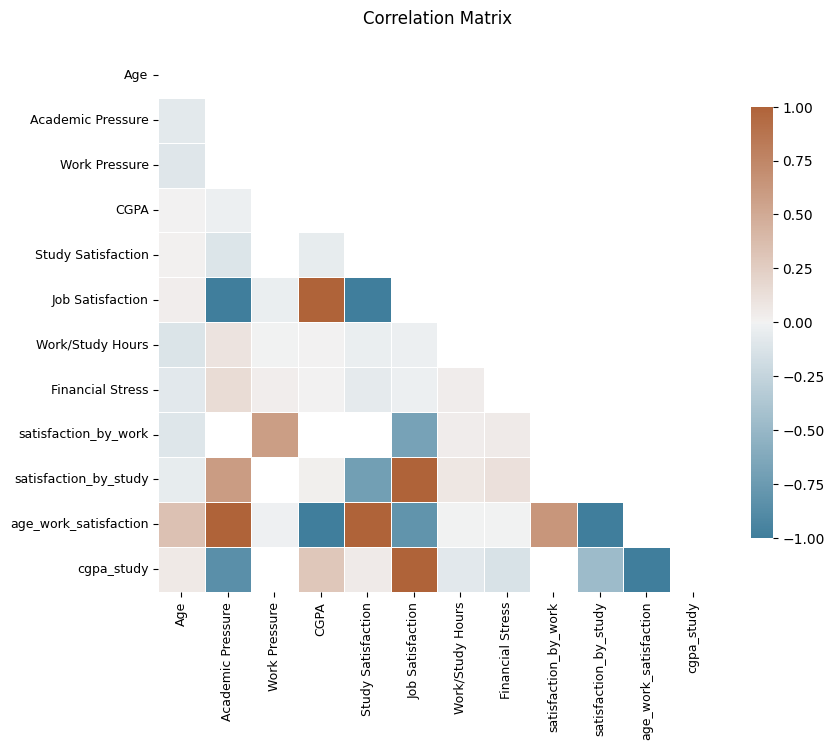

In [23]:
plt.style.use("default")
corr_mat = full_train[num_feats].corr()
mask = np.triu(np.ones_like(corr_mat, dtype=bool))
cmap = sns.diverging_palette(230, 30, as_cmap=True)
f, ax = plt.subplots(figsize=(9, 7))
sns.heatmap(
    corr_mat,
    mask=mask,
    cbar=True,
    cmap=cmap,
    center=0,
    square=False,
    annot=False,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
)
plt.title("Correlation Matrix\n")
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.show()

# Logistic Regression

In [25]:
logi_full_train = full_train.fillna("0")
logi_test_df = test_df.fillna("0")
logi_full_train = logi_full_train[pair_cols]
logit_num_feats_test = np.delete(pair_cols,12)
logi_test_df = logi_test_df[logit_num_feats_test]
logi_y = logi_full_train["Depression"]
logi_X = logi_full_train.drop(["Depression"], axis=1)
logi_X_train, logi_X_test, logi_y_train, logi_y_test = train_test_split(
    logi_X, logi_y, test_size=0.3, random_state=42)
logi_reg = LogisticRegression(max_iter = 2000)
logi_reg.fit(logi_X_train, logi_y_train)
logi_y_pred = logi_reg.predict(logi_X_test)
print('Accuracy of logistic regression classifier on validation set: {:.2f}'.format(logi_reg.score(logi_X_test, logi_y_test)))

Accuracy of logistic regression classifier on validation set: 0.92


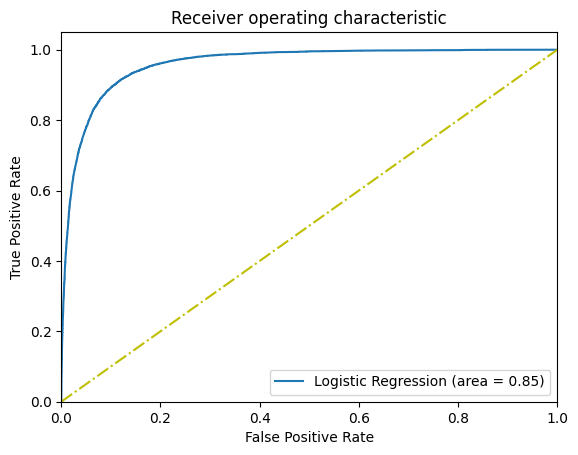

In [25]:
logit_roc_auc = roc_auc_score(logi_y_test, logi_reg.predict(logi_X_test))
fpr, tpr, thresholds = roc_curve(logi_y_test, logi_reg.predict_proba(logi_X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'y-.')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [26]:
from sklearn.metrics import classification_report
print(classification_report(logi_y_test, logi_y_pred))


              precision    recall  f1-score   support

           0       0.94      0.96      0.95     34434
           1       0.80      0.75      0.77      7776

    accuracy                           0.92     42210
   macro avg       0.87      0.85      0.86     42210
weighted avg       0.92      0.92      0.92     42210



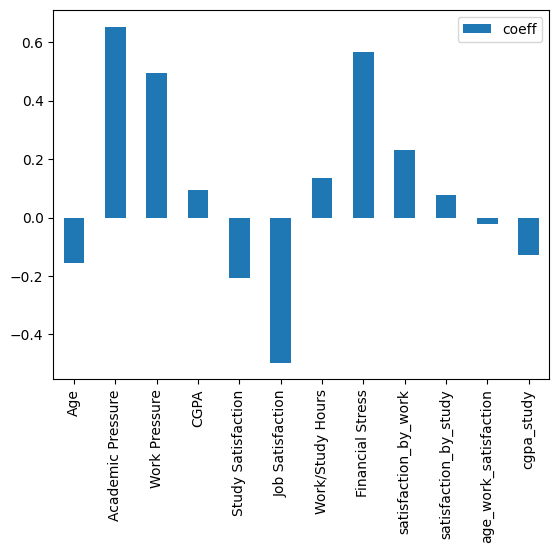

In [27]:
pd.DataFrame({'coeff': logi_reg.coef_[0]}, 
             index=logi_X.columns).plot(kind = "bar")
plt.show()

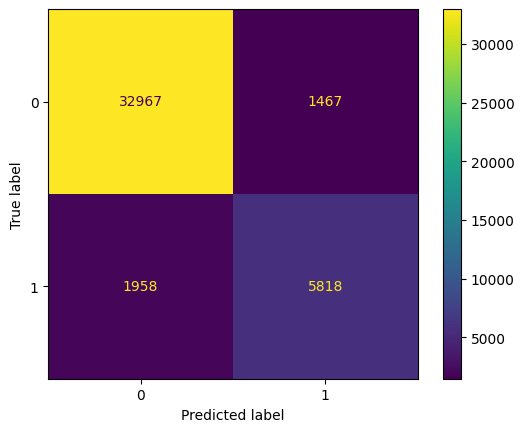

In [28]:
confusion_matrix = confusion_matrix(logi_y_test, logi_y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])
cm_display.plot()
plt.show()

# CatBoost

In [29]:
full_train = full_train.fillna("0")
test_df = test_df.fillna("0")
full_train[num_feats] = full_train[num_feats].astype("float64")
full_train[obj_feats] = full_train[obj_feats].astype("string")
full_train[target] = full_train[target].astype("int64")
test_df[num_feats] = test_df[num_feats].astype("float64")
test_df[obj_feats] = test_df[obj_feats].astype("string")

In [30]:
y = full_train["Depression"]
X = full_train.drop(["Depression"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=4
)

In [31]:
shap_df = (
    full_train
    .groupby('Depression')
    [full_train.columns.tolist()]
    .apply(lambda x: x.sample(frac=0.02), include_groups=True)
    .reset_index(drop=True)
    .copy()
    )
y_shap = shap_df["Depression"]
X_shap = shap_df.drop(["Depression"], axis=1)
X_train_shap, X_test_shap, y_train_shap, y_test_shap = train_test_split(
    X_shap, y_shap, test_size=0.2, random_state=1
)

In [35]:
def objective(trial):
    # Espacio de búsqueda para los hiperparámetros
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 4, 10),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1.0, 20.0),
        'random_strength': trial.suggest_float('random_strength', 0.0, 1.0),
    }

    # Modelo de CatBoost
    model = CatBoostClassifier(**params, cat_features=list(obj_feats), verbose=True)

    # Evaluación usando validación cruzada
    score = cross_val_score(model, X_shap, y_shap, cv=3, scoring='accuracy').mean()

    return score

# Crear un estudio con Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2024-12-02 21:42:20,999] A new study created in memory with name: no-name-4cf56907-8d85-45ac-b5df-15875a5ac817


0:	learn: 0.3927488	total: 63.9ms	remaining: 39.9s
1:	learn: 0.2790766	total: 68.1ms	remaining: 21.2s
2:	learn: 0.2341008	total: 72.1ms	remaining: 14.9s
3:	learn: 0.2179014	total: 75.1ms	remaining: 11.7s
4:	learn: 0.1977454	total: 77.7ms	remaining: 9.63s
5:	learn: 0.1831605	total: 80.4ms	remaining: 8.3s
6:	learn: 0.1741899	total: 83ms	remaining: 7.32s
7:	learn: 0.1649092	total: 85.4ms	remaining: 6.59s
8:	learn: 0.1575893	total: 87.9ms	remaining: 6.01s
9:	learn: 0.1547199	total: 89.2ms	remaining: 5.49s
10:	learn: 0.1495963	total: 92.5ms	remaining: 5.17s
11:	learn: 0.1467300	total: 95.2ms	remaining: 4.86s
12:	learn: 0.1417479	total: 97.8ms	remaining: 4.6s
13:	learn: 0.1382655	total: 100ms	remaining: 4.38s
14:	learn: 0.1358566	total: 103ms	remaining: 4.17s
15:	learn: 0.1327932	total: 105ms	remaining: 4.01s
16:	learn: 0.1291631	total: 108ms	remaining: 3.86s
17:	learn: 0.1254890	total: 110ms	remaining: 3.72s
18:	learn: 0.1228708	total: 113ms	remaining: 3.6s
19:	learn: 0.1193493	total: 116ms

[I 2024-12-02 21:42:26,255] Trial 0 finished with value: 0.9278606965174129 and parameters: {'iterations': 625, 'learning_rate': 0.29905489666650176, 'depth': 7, 'colsample_bylevel': 0.9045214050004065, 'subsample': 0.6819617507353355, 'min_data_in_leaf': 3, 'l2_leaf_reg': 19.868082837614434, 'random_strength': 0.6782755258770183}. Best is trial 0 with value: 0.9278606965174129.


592:	learn: 0.0101488	total: 1.57s	remaining: 84.8ms
593:	learn: 0.0101257	total: 1.57s	remaining: 82.2ms
594:	learn: 0.0101247	total: 1.58s	remaining: 79.5ms
595:	learn: 0.0101202	total: 1.58s	remaining: 76.8ms
596:	learn: 0.0100637	total: 1.58s	remaining: 74.2ms
597:	learn: 0.0100637	total: 1.58s	remaining: 71.6ms
598:	learn: 0.0100375	total: 1.59s	remaining: 68.9ms
599:	learn: 0.0100311	total: 1.59s	remaining: 66.3ms
600:	learn: 0.0100148	total: 1.59s	remaining: 63.7ms
601:	learn: 0.0099963	total: 1.6s	remaining: 61.1ms
602:	learn: 0.0099496	total: 1.6s	remaining: 58.4ms
603:	learn: 0.0099495	total: 1.6s	remaining: 55.8ms
604:	learn: 0.0099397	total: 1.61s	remaining: 53.1ms
605:	learn: 0.0099382	total: 1.61s	remaining: 50.5ms
606:	learn: 0.0098862	total: 1.61s	remaining: 47.8ms
607:	learn: 0.0098140	total: 1.61s	remaining: 45.1ms
608:	learn: 0.0097797	total: 1.62s	remaining: 42.5ms
609:	learn: 0.0097789	total: 1.62s	remaining: 39.8ms
610:	learn: 0.0097638	total: 1.62s	remaining: 37.

[I 2024-12-02 21:42:26,812] Trial 1 finished with value: 0.9299928926794597 and parameters: {'iterations': 135, 'learning_rate': 0.03418765538650078, 'depth': 4, 'colsample_bylevel': 0.8786102349804232, 'subsample': 0.7316606720219687, 'min_data_in_leaf': 8, 'l2_leaf_reg': 2.9717606116487083, 'random_strength': 0.01062041748369058}. Best is trial 1 with value: 0.9299928926794597.


97:	learn: 0.1504454	total: 117ms	remaining: 44.2ms
98:	learn: 0.1501280	total: 118ms	remaining: 43.1ms
99:	learn: 0.1499921	total: 120ms	remaining: 41.8ms
100:	learn: 0.1496153	total: 121ms	remaining: 40.8ms
101:	learn: 0.1495784	total: 122ms	remaining: 39.6ms
102:	learn: 0.1491289	total: 123ms	remaining: 38.3ms
103:	learn: 0.1490050	total: 125ms	remaining: 37.2ms
104:	learn: 0.1489573	total: 126ms	remaining: 36ms
105:	learn: 0.1489115	total: 127ms	remaining: 34.7ms
106:	learn: 0.1486046	total: 128ms	remaining: 33.5ms
107:	learn: 0.1481508	total: 129ms	remaining: 32.3ms
108:	learn: 0.1478017	total: 130ms	remaining: 31.1ms
109:	learn: 0.1471707	total: 132ms	remaining: 29.9ms
110:	learn: 0.1471318	total: 133ms	remaining: 28.7ms
111:	learn: 0.1471108	total: 134ms	remaining: 27.6ms
112:	learn: 0.1470907	total: 135ms	remaining: 26.4ms
113:	learn: 0.1470501	total: 137ms	remaining: 25.3ms
114:	learn: 0.1470164	total: 139ms	remaining: 24.1ms
115:	learn: 0.1469775	total: 140ms	remaining: 22.9m

[I 2024-12-02 21:42:33,226] Trial 2 finished with value: 0.9275053304904052 and parameters: {'iterations': 894, 'learning_rate': 0.06702556474675155, 'depth': 6, 'colsample_bylevel': 0.77367758890116, 'subsample': 0.788450322002044, 'min_data_in_leaf': 2, 'l2_leaf_reg': 1.1108321944335486, 'random_strength': 0.09527753203668121}. Best is trial 1 with value: 0.9299928926794597.


817:	learn: 0.0056092	total: 1.91s	remaining: 178ms
818:	learn: 0.0056016	total: 1.91s	remaining: 175ms
819:	learn: 0.0055918	total: 1.92s	remaining: 173ms
820:	learn: 0.0055858	total: 1.92s	remaining: 171ms
821:	learn: 0.0055775	total: 1.92s	remaining: 168ms
822:	learn: 0.0055571	total: 1.92s	remaining: 166ms
823:	learn: 0.0055537	total: 1.93s	remaining: 164ms
824:	learn: 0.0055367	total: 1.93s	remaining: 161ms
825:	learn: 0.0055136	total: 1.93s	remaining: 159ms
826:	learn: 0.0055136	total: 1.93s	remaining: 157ms
827:	learn: 0.0055054	total: 1.93s	remaining: 154ms
828:	learn: 0.0054904	total: 1.94s	remaining: 152ms
829:	learn: 0.0054741	total: 1.94s	remaining: 150ms
830:	learn: 0.0054686	total: 1.94s	remaining: 147ms
831:	learn: 0.0054479	total: 1.94s	remaining: 145ms
832:	learn: 0.0054448	total: 1.95s	remaining: 142ms
833:	learn: 0.0054385	total: 1.95s	remaining: 140ms
834:	learn: 0.0054265	total: 1.95s	remaining: 138ms
835:	learn: 0.0054190	total: 1.95s	remaining: 135ms
836:	learn: 

[I 2024-12-02 21:42:41,183] Trial 3 finished with value: 0.9260838663823737 and parameters: {'iterations': 912, 'learning_rate': 0.11556129027233134, 'depth': 8, 'colsample_bylevel': 0.5149417625996608, 'subsample': 0.5726932135649333, 'min_data_in_leaf': 8, 'l2_leaf_reg': 13.078329921195635, 'random_strength': 0.06927423976327374}. Best is trial 1 with value: 0.9299928926794597.


910:	learn: 0.0075784	total: 2.57s	remaining: 2.82ms
911:	learn: 0.0075536	total: 2.57s	remaining: 0us
0:	learn: 0.6256739	total: 1.09ms	remaining: 754ms
1:	learn: 0.5387644	total: 5.04ms	remaining: 1.74s
2:	learn: 0.4638529	total: 9.24ms	remaining: 2.12s
3:	learn: 0.4091209	total: 10.5ms	remaining: 1.8s
4:	learn: 0.3686641	total: 12.6ms	remaining: 1.73s
5:	learn: 0.3401731	total: 14.3ms	remaining: 1.63s
6:	learn: 0.3060343	total: 18.9ms	remaining: 1.85s
7:	learn: 0.2874907	total: 23ms	remaining: 1.97s
8:	learn: 0.2630688	total: 27.6ms	remaining: 2.09s
9:	learn: 0.2476403	total: 29.4ms	remaining: 2s
10:	learn: 0.2373140	total: 34ms	remaining: 2.1s
11:	learn: 0.2236428	total: 38.8ms	remaining: 2.2s
12:	learn: 0.2145297	total: 43.1ms	remaining: 2.25s
13:	learn: 0.2118672	total: 44ms	remaining: 2.13s
14:	learn: 0.2040021	total: 48.3ms	remaining: 2.18s
15:	learn: 0.1968920	total: 53.5ms	remaining: 2.26s
16:	learn: 0.1897387	total: 57.8ms	remaining: 2.29s
17:	learn: 0.1818738	total: 62.1ms	

[I 2024-12-02 21:42:50,805] Trial 4 finished with value: 0.9292821606254442 and parameters: {'iterations': 692, 'learning_rate': 0.08751547082535771, 'depth': 10, 'colsample_bylevel': 0.5074044003564135, 'subsample': 0.7492600780291218, 'min_data_in_leaf': 3, 'l2_leaf_reg': 7.092763291561641, 'random_strength': 0.8661775102347102}. Best is trial 1 with value: 0.9299928926794597.


679:	learn: 0.0040934	total: 3.02s	remaining: 53.3ms
680:	learn: 0.0040856	total: 3.03s	remaining: 48.9ms
681:	learn: 0.0040783	total: 3.03s	remaining: 44.5ms
682:	learn: 0.0040710	total: 3.04s	remaining: 40ms
683:	learn: 0.0040640	total: 3.04s	remaining: 35.6ms
684:	learn: 0.0040576	total: 3.05s	remaining: 31.1ms
685:	learn: 0.0040474	total: 3.05s	remaining: 26.7ms
686:	learn: 0.0040390	total: 3.06s	remaining: 22.2ms
687:	learn: 0.0040314	total: 3.06s	remaining: 17.8ms
688:	learn: 0.0040247	total: 3.07s	remaining: 13.3ms
689:	learn: 0.0040186	total: 3.07s	remaining: 8.9ms
690:	learn: 0.0040112	total: 3.08s	remaining: 4.45ms
691:	learn: 0.0040033	total: 3.08s	remaining: 0us
0:	learn: 0.3865557	total: 3.15ms	remaining: 1.57s
1:	learn: 0.2860662	total: 6.27ms	remaining: 1.56s
2:	learn: 0.2418427	total: 9.7ms	remaining: 1.61s
3:	learn: 0.2123340	total: 13ms	remaining: 1.62s
4:	learn: 0.1949378	total: 16.3ms	remaining: 1.61s
5:	learn: 0.1806058	total: 19.1ms	remaining: 1.58s
6:	learn: 0.16

[I 2024-12-02 21:42:56,080] Trial 5 finished with value: 0.9282160625444208 and parameters: {'iterations': 501, 'learning_rate': 0.2769087063440699, 'depth': 8, 'colsample_bylevel': 0.9333283134854569, 'subsample': 0.7478231139266782, 'min_data_in_leaf': 5, 'l2_leaf_reg': 18.21168548757901, 'random_strength': 0.46231451899065934}. Best is trial 1 with value: 0.9299928926794597.


475:	learn: 0.0079895	total: 1.58s	remaining: 83ms
476:	learn: 0.0079616	total: 1.58s	remaining: 79.7ms
477:	learn: 0.0079616	total: 1.58s	remaining: 76.3ms
478:	learn: 0.0079555	total: 1.59s	remaining: 72.9ms
479:	learn: 0.0079518	total: 1.59s	remaining: 69.6ms
480:	learn: 0.0079480	total: 1.59s	remaining: 66.2ms
481:	learn: 0.0079145	total: 1.6s	remaining: 62.9ms
482:	learn: 0.0079140	total: 1.6s	remaining: 59.7ms
483:	learn: 0.0078884	total: 1.6s	remaining: 56.4ms
484:	learn: 0.0078884	total: 1.61s	remaining: 53ms
485:	learn: 0.0078645	total: 1.61s	remaining: 49.7ms
486:	learn: 0.0078569	total: 1.61s	remaining: 46.4ms
487:	learn: 0.0078568	total: 1.62s	remaining: 43.1ms
488:	learn: 0.0078566	total: 1.62s	remaining: 39.7ms
489:	learn: 0.0078563	total: 1.62s	remaining: 36.4ms
490:	learn: 0.0078563	total: 1.62s	remaining: 33.1ms
491:	learn: 0.0078562	total: 1.63s	remaining: 29.8ms
492:	learn: 0.0078249	total: 1.63s	remaining: 26.4ms
493:	learn: 0.0077920	total: 1.63s	remaining: 23.1ms


[I 2024-12-02 21:43:04,115] Trial 6 finished with value: 0.9282160625444207 and parameters: {'iterations': 938, 'learning_rate': 0.09550880276704041, 'depth': 7, 'colsample_bylevel': 0.9595707639761053, 'subsample': 0.737053688097175, 'min_data_in_leaf': 4, 'l2_leaf_reg': 18.545981273674883, 'random_strength': 0.1540882058670504}. Best is trial 1 with value: 0.9299928926794597.


0:	learn: 0.6522214	total: 4.61ms	remaining: 4.07s
1:	learn: 0.6119036	total: 7.42ms	remaining: 3.27s
2:	learn: 0.5723840	total: 9.56ms	remaining: 2.81s
3:	learn: 0.5403483	total: 12.3ms	remaining: 2.72s
4:	learn: 0.5057975	total: 14.5ms	remaining: 2.54s
5:	learn: 0.4796357	total: 17.1ms	remaining: 2.51s
6:	learn: 0.4515254	total: 19.6ms	remaining: 2.45s
7:	learn: 0.4324360	total: 22ms	remaining: 2.41s
8:	learn: 0.4132226	total: 24.6ms	remaining: 2.39s
9:	learn: 0.3951273	total: 27.2ms	remaining: 2.38s
10:	learn: 0.3760157	total: 29.1ms	remaining: 2.31s
11:	learn: 0.3624546	total: 32ms	remaining: 2.33s
12:	learn: 0.3488192	total: 34.8ms	remaining: 2.33s
13:	learn: 0.3389272	total: 37.1ms	remaining: 2.31s
14:	learn: 0.3265092	total: 39.7ms	remaining: 2.3s
15:	learn: 0.3150457	total: 42.1ms	remaining: 2.28s
16:	learn: 0.3075703	total: 44.3ms	remaining: 2.26s
17:	learn: 0.2986856	total: 47.1ms	remaining: 2.27s
18:	learn: 0.2909841	total: 49.6ms	remaining: 2.26s
19:	learn: 0.2839798	total:

[I 2024-12-02 21:43:11,327] Trial 7 finished with value: 0.9299928926794597 and parameters: {'iterations': 884, 'learning_rate': 0.03332617725902262, 'depth': 7, 'colsample_bylevel': 0.8370339972741965, 'subsample': 0.6324509561390816, 'min_data_in_leaf': 5, 'l2_leaf_reg': 18.02231924946181, 'random_strength': 0.25711180309476633}. Best is trial 1 with value: 0.9299928926794597.


849:	learn: 0.0623832	total: 2.17s	remaining: 86.8ms
850:	learn: 0.0623804	total: 2.17s	remaining: 84.2ms
851:	learn: 0.0623664	total: 2.17s	remaining: 81.7ms
852:	learn: 0.0623602	total: 2.18s	remaining: 79.1ms
853:	learn: 0.0623219	total: 2.18s	remaining: 76.6ms
854:	learn: 0.0622415	total: 2.18s	remaining: 74ms
855:	learn: 0.0622394	total: 2.19s	remaining: 71.5ms
856:	learn: 0.0621099	total: 2.19s	remaining: 68.9ms
857:	learn: 0.0621062	total: 2.19s	remaining: 66.4ms
858:	learn: 0.0620536	total: 2.19s	remaining: 63.8ms
859:	learn: 0.0620246	total: 2.19s	remaining: 61.3ms
860:	learn: 0.0620214	total: 2.2s	remaining: 58.7ms
861:	learn: 0.0619828	total: 2.2s	remaining: 56.2ms
862:	learn: 0.0619731	total: 2.2s	remaining: 53.6ms
863:	learn: 0.0619334	total: 2.21s	remaining: 51.1ms
864:	learn: 0.0618513	total: 2.21s	remaining: 48.5ms
865:	learn: 0.0618337	total: 2.21s	remaining: 46ms
866:	learn: 0.0618074	total: 2.21s	remaining: 43.4ms
867:	learn: 0.0617939	total: 2.22s	remaining: 40.9ms


[I 2024-12-02 21:43:15,343] Trial 8 finished with value: 0.9285714285714285 and parameters: {'iterations': 800, 'learning_rate': 0.07299688257584017, 'depth': 4, 'colsample_bylevel': 0.6128758346707825, 'subsample': 0.9516246522809262, 'min_data_in_leaf': 3, 'l2_leaf_reg': 17.982398180275638, 'random_strength': 0.1343058672439893}. Best is trial 1 with value: 0.9299928926794597.


756:	learn: 0.0789864	total: 1.2s	remaining: 68.1ms
757:	learn: 0.0789616	total: 1.2s	remaining: 66.5ms
758:	learn: 0.0789591	total: 1.2s	remaining: 64.9ms
759:	learn: 0.0789497	total: 1.2s	remaining: 63.4ms
760:	learn: 0.0789414	total: 1.21s	remaining: 61.8ms
761:	learn: 0.0789341	total: 1.21s	remaining: 60.2ms
762:	learn: 0.0788232	total: 1.21s	remaining: 58.6ms
763:	learn: 0.0787949	total: 1.21s	remaining: 57ms
764:	learn: 0.0787267	total: 1.21s	remaining: 55.4ms
765:	learn: 0.0786734	total: 1.21s	remaining: 53.8ms
766:	learn: 0.0784138	total: 1.21s	remaining: 52.2ms
767:	learn: 0.0783240	total: 1.22s	remaining: 50.7ms
768:	learn: 0.0783224	total: 1.22s	remaining: 49.1ms
769:	learn: 0.0780449	total: 1.22s	remaining: 47.5ms
770:	learn: 0.0779639	total: 1.22s	remaining: 45.9ms
771:	learn: 0.0778702	total: 1.22s	remaining: 44.3ms
772:	learn: 0.0778642	total: 1.22s	remaining: 42.7ms
773:	learn: 0.0778184	total: 1.23s	remaining: 41.2ms
774:	learn: 0.0777838	total: 1.23s	remaining: 39.6ms

[I 2024-12-02 21:43:24,479] Trial 9 finished with value: 0.9264392324093818 and parameters: {'iterations': 897, 'learning_rate': 0.09776513592724961, 'depth': 8, 'colsample_bylevel': 0.9595969170697631, 'subsample': 0.6262701683229245, 'min_data_in_leaf': 5, 'l2_leaf_reg': 2.666792447722564, 'random_strength': 0.6873921533975332}. Best is trial 1 with value: 0.9299928926794597.


879:	learn: 0.0029211	total: 2.88s	remaining: 55.7ms
880:	learn: 0.0029210	total: 2.89s	remaining: 52.4ms
881:	learn: 0.0029098	total: 2.89s	remaining: 49.2ms
882:	learn: 0.0029098	total: 2.89s	remaining: 45.9ms
883:	learn: 0.0029045	total: 2.9s	remaining: 42.6ms
884:	learn: 0.0029045	total: 2.9s	remaining: 39.4ms
885:	learn: 0.0029045	total: 2.9s	remaining: 36.1ms
886:	learn: 0.0029044	total: 2.91s	remaining: 32.8ms
887:	learn: 0.0029016	total: 2.91s	remaining: 29.5ms
888:	learn: 0.0029016	total: 2.91s	remaining: 26.2ms
889:	learn: 0.0028873	total: 2.92s	remaining: 22.9ms
890:	learn: 0.0028873	total: 2.92s	remaining: 19.7ms
891:	learn: 0.0028873	total: 2.92s	remaining: 16.4ms
892:	learn: 0.0028871	total: 2.92s	remaining: 13.1ms
893:	learn: 0.0028839	total: 2.93s	remaining: 9.83ms
894:	learn: 0.0028787	total: 2.93s	remaining: 6.55ms
895:	learn: 0.0028728	total: 2.93s	remaining: 3.27ms
896:	learn: 0.0028728	total: 2.94s	remaining: 0us
0:	learn: 0.4439367	total: 1.8ms	remaining: 329ms
1:

[I 2024-12-02 21:43:25,220] Trial 10 finished with value: 0.9289267945984364 and parameters: {'iterations': 184, 'learning_rate': 0.19419695855182384, 'depth': 4, 'colsample_bylevel': 0.6882486609469843, 'subsample': 0.8788657399893183, 'min_data_in_leaf': 10, 'l2_leaf_reg': 5.981353176801552, 'random_strength': 0.341470433670926}. Best is trial 1 with value: 0.9299928926794597.


183:	learn: 0.0665407	total: 221ms	remaining: 0us
0:	learn: 0.6700882	total: 1.29ms	remaining: 171ms
1:	learn: 0.6497287	total: 3.35ms	remaining: 221ms
2:	learn: 0.6270383	total: 4.53ms	remaining: 198ms
3:	learn: 0.6065114	total: 5.93ms	remaining: 193ms
4:	learn: 0.5878632	total: 7.17ms	remaining: 185ms
5:	learn: 0.5691055	total: 8.78ms	remaining: 187ms
6:	learn: 0.5533365	total: 10.1ms	remaining: 184ms
7:	learn: 0.5369921	total: 11.3ms	remaining: 179ms
8:	learn: 0.5221479	total: 12.5ms	remaining: 173ms
9:	learn: 0.5144802	total: 13.3ms	remaining: 166ms
10:	learn: 0.4994517	total: 14.4ms	remaining: 161ms
11:	learn: 0.4851589	total: 16.4ms	remaining: 167ms
12:	learn: 0.4708802	total: 17.9ms	remaining: 167ms
13:	learn: 0.4578160	total: 19.1ms	remaining: 164ms
14:	learn: 0.4453803	total: 20.9ms	remaining: 166ms
15:	learn: 0.4346555	total: 22.3ms	remaining: 164ms
16:	learn: 0.4230866	total: 23.4ms	remaining: 161ms
17:	learn: 0.4127685	total: 24.7ms	remaining: 159ms
18:	learn: 0.4034373	tot

[I 2024-12-02 21:43:25,815] Trial 11 finished with value: 0.9292821606254442 and parameters: {'iterations': 134, 'learning_rate': 0.01568298113049274, 'depth': 5, 'colsample_bylevel': 0.8247724552526929, 'subsample': 0.5030024791181371, 'min_data_in_leaf': 7, 'l2_leaf_reg': 12.718623244896424, 'random_strength': 0.30464198890026795}. Best is trial 1 with value: 0.9299928926794597.


128:	learn: 0.1650704	total: 186ms	remaining: 7.21ms
129:	learn: 0.1646126	total: 187ms	remaining: 5.76ms
130:	learn: 0.1642424	total: 189ms	remaining: 4.32ms
131:	learn: 0.1638941	total: 190ms	remaining: 2.88ms
132:	learn: 0.1634982	total: 191ms	remaining: 1.44ms
133:	learn: 0.1629597	total: 192ms	remaining: 0us
0:	learn: 0.6691677	total: 2.15ms	remaining: 286ms
1:	learn: 0.6470583	total: 3.69ms	remaining: 243ms
2:	learn: 0.6249082	total: 4.91ms	remaining: 214ms
3:	learn: 0.6063109	total: 6.46ms	remaining: 210ms
4:	learn: 0.5863726	total: 7.54ms	remaining: 195ms
5:	learn: 0.5687700	total: 8.71ms	remaining: 186ms
6:	learn: 0.5510085	total: 9.76ms	remaining: 177ms
7:	learn: 0.5341354	total: 11ms	remaining: 174ms
8:	learn: 0.5174416	total: 12.2ms	remaining: 170ms
9:	learn: 0.5091697	total: 13ms	remaining: 162ms
10:	learn: 0.4940528	total: 14.2ms	remaining: 159ms
11:	learn: 0.4801740	total: 15.7ms	remaining: 160ms
12:	learn: 0.4665533	total: 16.9ms	remaining: 157ms
13:	learn: 0.4533543	to

[I 2024-12-02 21:43:31,763] Trial 12 finished with value: 0.9292821606254442 and parameters: {'iterations': 382, 'learning_rate': 0.010899812631781317, 'depth': 10, 'colsample_bylevel': 0.8410504975594596, 'subsample': 0.6371475630875202, 'min_data_in_leaf': 7, 'l2_leaf_reg': 8.654947830203511, 'random_strength': 0.007117159391724748}. Best is trial 1 with value: 0.9299928926794597.


0:	learn: 0.4701072	total: 1.91ms	remaining: 612ms
1:	learn: 0.3542728	total: 4.04ms	remaining: 646ms
2:	learn: 0.2963190	total: 6.01ms	remaining: 639ms
3:	learn: 0.2544137	total: 7.95ms	remaining: 632ms
4:	learn: 0.2303793	total: 10.5ms	remaining: 664ms
5:	learn: 0.2140509	total: 12.3ms	remaining: 647ms
6:	learn: 0.2019655	total: 14.3ms	remaining: 643ms
7:	learn: 0.1919541	total: 16ms	remaining: 629ms
8:	learn: 0.1841601	total: 17.9ms	remaining: 621ms
9:	learn: 0.1783923	total: 19.6ms	remaining: 613ms
10:	learn: 0.1743116	total: 21.7ms	remaining: 613ms
11:	learn: 0.1711626	total: 23.9ms	remaining: 616ms
12:	learn: 0.1693444	total: 26.6ms	remaining: 633ms
13:	learn: 0.1646837	total: 29.1ms	remaining: 641ms
14:	learn: 0.1616880	total: 30.9ms	remaining: 633ms
15:	learn: 0.1608760	total: 33.1ms	remaining: 633ms
16:	learn: 0.1582626	total: 34.6ms	remaining: 621ms
17:	learn: 0.1548044	total: 36.5ms	remaining: 617ms
18:	learn: 0.1532704	total: 39.1ms	remaining: 623ms
19:	learn: 0.1520032	tot

[I 2024-12-02 21:43:33,769] Trial 13 finished with value: 0.9271499644633973 and parameters: {'iterations': 322, 'learning_rate': 0.1735240063890941, 'depth': 5, 'colsample_bylevel': 0.8611562038110726, 'subsample': 0.8419184661262362, 'min_data_in_leaf': 10, 'l2_leaf_reg': 14.617000831036703, 'random_strength': 0.2858892926780401}. Best is trial 1 with value: 0.9299928926794597.


244:	learn: 0.0693257	total: 470ms	remaining: 148ms
245:	learn: 0.0693232	total: 471ms	remaining: 146ms
246:	learn: 0.0691329	total: 473ms	remaining: 144ms
247:	learn: 0.0689116	total: 476ms	remaining: 142ms
248:	learn: 0.0686622	total: 478ms	remaining: 140ms
249:	learn: 0.0686331	total: 480ms	remaining: 138ms
250:	learn: 0.0686264	total: 481ms	remaining: 136ms
251:	learn: 0.0680443	total: 483ms	remaining: 134ms
252:	learn: 0.0675408	total: 485ms	remaining: 132ms
253:	learn: 0.0674148	total: 487ms	remaining: 130ms
254:	learn: 0.0670692	total: 489ms	remaining: 129ms
255:	learn: 0.0665988	total: 491ms	remaining: 127ms
256:	learn: 0.0660804	total: 493ms	remaining: 125ms
257:	learn: 0.0658823	total: 495ms	remaining: 123ms
258:	learn: 0.0655002	total: 496ms	remaining: 121ms
259:	learn: 0.0653352	total: 498ms	remaining: 119ms
260:	learn: 0.0653292	total: 500ms	remaining: 117ms
261:	learn: 0.0649826	total: 502ms	remaining: 115ms
262:	learn: 0.0647522	total: 504ms	remaining: 113ms
263:	learn: 

[I 2024-12-02 21:43:37,208] Trial 14 finished with value: 0.9296375266524519 and parameters: {'iterations': 498, 'learning_rate': 0.04699383077772489, 'depth': 6, 'colsample_bylevel': 0.7311074393312982, 'subsample': 0.5675379390571113, 'min_data_in_leaf': 8, 'l2_leaf_reg': 4.071382427515732, 'random_strength': 0.20783103234753716}. Best is trial 1 with value: 0.9299928926794597.


437:	learn: 0.0521063	total: 942ms	remaining: 129ms
438:	learn: 0.0520176	total: 944ms	remaining: 127ms
439:	learn: 0.0518615	total: 947ms	remaining: 125ms
440:	learn: 0.0518554	total: 949ms	remaining: 123ms
441:	learn: 0.0517706	total: 952ms	remaining: 121ms
442:	learn: 0.0516812	total: 955ms	remaining: 119ms
443:	learn: 0.0514240	total: 956ms	remaining: 116ms
444:	learn: 0.0513577	total: 959ms	remaining: 114ms
445:	learn: 0.0513179	total: 961ms	remaining: 112ms
446:	learn: 0.0512782	total: 962ms	remaining: 110ms
447:	learn: 0.0511333	total: 965ms	remaining: 108ms
448:	learn: 0.0508969	total: 967ms	remaining: 106ms
449:	learn: 0.0508725	total: 969ms	remaining: 103ms
450:	learn: 0.0508642	total: 971ms	remaining: 101ms
451:	learn: 0.0507970	total: 973ms	remaining: 99ms
452:	learn: 0.0505706	total: 975ms	remaining: 96.8ms
453:	learn: 0.0505684	total: 977ms	remaining: 94.7ms
454:	learn: 0.0503462	total: 979ms	remaining: 92.5ms
455:	learn: 0.0502218	total: 981ms	remaining: 90.4ms
456:	lear

[I 2024-12-02 21:43:51,917] Trial 15 finished with value: 0.9307036247334755 and parameters: {'iterations': 738, 'learning_rate': 0.2298206132202802, 'depth': 9, 'colsample_bylevel': 0.7928114943417377, 'subsample': 0.6807996462411781, 'min_data_in_leaf': 6, 'l2_leaf_reg': 10.187748776680657, 'random_strength': 0.45150897257620837}. Best is trial 15 with value: 0.9307036247334755.


718:	learn: 0.0029897	total: 4.72s	remaining: 125ms
719:	learn: 0.0029784	total: 4.73s	remaining: 118ms
720:	learn: 0.0029717	total: 4.74s	remaining: 112ms
721:	learn: 0.0029716	total: 4.74s	remaining: 105ms
722:	learn: 0.0029716	total: 4.75s	remaining: 98.6ms
723:	learn: 0.0029716	total: 4.76s	remaining: 92ms
724:	learn: 0.0029606	total: 4.76s	remaining: 85.4ms
725:	learn: 0.0029606	total: 4.77s	remaining: 78.9ms
726:	learn: 0.0029545	total: 4.78s	remaining: 72.3ms
727:	learn: 0.0029468	total: 4.79s	remaining: 65.7ms
728:	learn: 0.0029359	total: 4.79s	remaining: 59.2ms
729:	learn: 0.0029359	total: 4.8s	remaining: 52.6ms
730:	learn: 0.0029359	total: 4.8s	remaining: 46ms
731:	learn: 0.0029358	total: 4.81s	remaining: 39.4ms
732:	learn: 0.0029358	total: 4.82s	remaining: 32.9ms
733:	learn: 0.0029358	total: 4.82s	remaining: 26.3ms
734:	learn: 0.0029307	total: 4.83s	remaining: 19.7ms
735:	learn: 0.0029256	total: 4.84s	remaining: 13.1ms
736:	learn: 0.0029149	total: 4.84s	remaining: 6.57ms
737

[I 2024-12-02 21:44:06,619] Trial 16 finished with value: 0.9260838663823737 and parameters: {'iterations': 726, 'learning_rate': 0.2341427248032436, 'depth': 9, 'colsample_bylevel': 0.7662203346904143, 'subsample': 0.8286009498249586, 'min_data_in_leaf': 7, 'l2_leaf_reg': 9.583663075906173, 'random_strength': 0.9932436206092643}. Best is trial 15 with value: 0.9307036247334755.


714:	learn: 0.0023289	total: 4.68s	remaining: 72ms
715:	learn: 0.0023289	total: 4.69s	remaining: 65.5ms
716:	learn: 0.0023232	total: 4.7s	remaining: 58.9ms
717:	learn: 0.0023182	total: 4.7s	remaining: 52.4ms
718:	learn: 0.0023182	total: 4.71s	remaining: 45.8ms
719:	learn: 0.0023139	total: 4.72s	remaining: 39.3ms
720:	learn: 0.0023105	total: 4.72s	remaining: 32.8ms
721:	learn: 0.0023046	total: 4.73s	remaining: 26.2ms
722:	learn: 0.0022994	total: 4.74s	remaining: 19.7ms
723:	learn: 0.0022970	total: 4.74s	remaining: 13.1ms
724:	learn: 0.0022970	total: 4.75s	remaining: 6.55ms
725:	learn: 0.0022925	total: 4.75s	remaining: 0us
0:	learn: 0.5037878	total: 4.79ms	remaining: 1.45s
1:	learn: 0.3859269	total: 12ms	remaining: 1.81s
2:	learn: 0.3304357	total: 18.7ms	remaining: 1.87s
3:	learn: 0.2834159	total: 24.3ms	remaining: 1.82s
4:	learn: 0.2444291	total: 30.8ms	remaining: 1.83s
5:	learn: 0.2146346	total: 37.5ms	remaining: 1.85s
6:	learn: 0.1924267	total: 43.4ms	remaining: 1.84s
7:	learn: 0.1796

[I 2024-12-02 21:44:12,786] Trial 17 finished with value: 0.9321250888415067 and parameters: {'iterations': 303, 'learning_rate': 0.14064893370990172, 'depth': 9, 'colsample_bylevel': 0.998755272713093, 'subsample': 0.6933734182354948, 'min_data_in_leaf': 9, 'l2_leaf_reg': 4.804144007449299, 'random_strength': 0.475734386283544}. Best is trial 17 with value: 0.9321250888415067.


283:	learn: 0.0078472	total: 1.85s	remaining: 124ms
284:	learn: 0.0077960	total: 1.86s	remaining: 117ms
285:	learn: 0.0077533	total: 1.87s	remaining: 111ms
286:	learn: 0.0077155	total: 1.87s	remaining: 104ms
287:	learn: 0.0076712	total: 1.88s	remaining: 98ms
288:	learn: 0.0076681	total: 1.89s	remaining: 91.4ms
289:	learn: 0.0076319	total: 1.9s	remaining: 85ms
290:	learn: 0.0076070	total: 1.9s	remaining: 78.5ms
291:	learn: 0.0075887	total: 1.91s	remaining: 72ms
292:	learn: 0.0075544	total: 1.92s	remaining: 65.4ms
293:	learn: 0.0075043	total: 1.92s	remaining: 58.8ms
294:	learn: 0.0074876	total: 1.93s	remaining: 52.3ms
295:	learn: 0.0074827	total: 1.93s	remaining: 45.7ms
296:	learn: 0.0074390	total: 1.94s	remaining: 39.2ms
297:	learn: 0.0073804	total: 1.95s	remaining: 32.7ms
298:	learn: 0.0073105	total: 1.96s	remaining: 26.2ms
299:	learn: 0.0072735	total: 1.96s	remaining: 19.6ms
300:	learn: 0.0072304	total: 1.97s	remaining: 13.1ms
301:	learn: 0.0071822	total: 1.98s	remaining: 6.54ms
302:	

[I 2024-12-02 21:44:18,740] Trial 18 finished with value: 0.9289267945984364 and parameters: {'iterations': 298, 'learning_rate': 0.14236074566199552, 'depth': 9, 'colsample_bylevel': 0.9911769577261815, 'subsample': 0.6864157878918626, 'min_data_in_leaf': 1, 'l2_leaf_reg': 11.169865559750262, 'random_strength': 0.517293594824491}. Best is trial 17 with value: 0.9321250888415067.


277:	learn: 0.0145671	total: 1.78s	remaining: 128ms
278:	learn: 0.0145671	total: 1.78s	remaining: 122ms
279:	learn: 0.0145554	total: 1.79s	remaining: 115ms
280:	learn: 0.0144590	total: 1.8s	remaining: 109ms
281:	learn: 0.0144584	total: 1.81s	remaining: 103ms
282:	learn: 0.0143653	total: 1.82s	remaining: 96.3ms
283:	learn: 0.0143616	total: 1.82s	remaining: 89.9ms
284:	learn: 0.0142790	total: 1.83s	remaining: 83.5ms
285:	learn: 0.0141867	total: 1.83s	remaining: 77ms
286:	learn: 0.0141398	total: 1.84s	remaining: 70.6ms
287:	learn: 0.0141375	total: 1.85s	remaining: 64.2ms
288:	learn: 0.0140620	total: 1.85s	remaining: 57.8ms
289:	learn: 0.0139647	total: 1.86s	remaining: 51.4ms
290:	learn: 0.0138856	total: 1.87s	remaining: 45ms
291:	learn: 0.0138175	total: 1.88s	remaining: 38.5ms
292:	learn: 0.0137625	total: 1.88s	remaining: 32.1ms
293:	learn: 0.0136976	total: 1.89s	remaining: 25.7ms
294:	learn: 0.0136377	total: 1.9s	remaining: 19.3ms
295:	learn: 0.0136376	total: 1.9s	remaining: 12.9ms
296:	

[I 2024-12-02 21:44:30,041] Trial 19 finished with value: 0.9282160625444208 and parameters: {'iterations': 581, 'learning_rate': 0.22406270914384596, 'depth': 9, 'colsample_bylevel': 0.640118460208162, 'subsample': 0.9784752458344776, 'min_data_in_leaf': 9, 'l2_leaf_reg': 5.895915366119238, 'random_strength': 0.46014568182042076}. Best is trial 17 with value: 0.9321250888415067.


553:	learn: 0.0020811	total: 3.53s	remaining: 172ms
554:	learn: 0.0020811	total: 3.54s	remaining: 166ms
555:	learn: 0.0020811	total: 3.54s	remaining: 159ms
556:	learn: 0.0020811	total: 3.55s	remaining: 153ms
557:	learn: 0.0020760	total: 3.55s	remaining: 147ms
558:	learn: 0.0020760	total: 3.56s	remaining: 140ms
559:	learn: 0.0020695	total: 3.57s	remaining: 134ms
560:	learn: 0.0020695	total: 3.57s	remaining: 127ms
561:	learn: 0.0020695	total: 3.58s	remaining: 121ms
562:	learn: 0.0020695	total: 3.59s	remaining: 115ms
563:	learn: 0.0020622	total: 3.6s	remaining: 108ms
564:	learn: 0.0020574	total: 3.6s	remaining: 102ms
565:	learn: 0.0020574	total: 3.61s	remaining: 95.6ms
566:	learn: 0.0020574	total: 3.61s	remaining: 89.2ms
567:	learn: 0.0020574	total: 3.62s	remaining: 82.9ms
568:	learn: 0.0020574	total: 3.63s	remaining: 76.5ms
569:	learn: 0.0020574	total: 3.63s	remaining: 70.1ms
570:	learn: 0.0020565	total: 3.64s	remaining: 63.7ms
571:	learn: 0.0020565	total: 3.64s	remaining: 57.3ms
572:	le

[I 2024-12-02 21:44:35,881] Trial 20 finished with value: 0.9260838663823737 and parameters: {'iterations': 402, 'learning_rate': 0.1359115776841315, 'depth': 10, 'colsample_bylevel': 0.5831520889809799, 'subsample': 0.6913351625852526, 'min_data_in_leaf': 6, 'l2_leaf_reg': 7.856764884954323, 'random_strength': 0.5899369713295396}. Best is trial 17 with value: 0.9321250888415067.


387:	learn: 0.0052224	total: 1.82s	remaining: 65.7ms
388:	learn: 0.0052040	total: 1.82s	remaining: 61ms
389:	learn: 0.0051980	total: 1.83s	remaining: 56.3ms
390:	learn: 0.0051811	total: 1.83s	remaining: 51.6ms
391:	learn: 0.0051640	total: 1.84s	remaining: 46.9ms
392:	learn: 0.0051427	total: 1.84s	remaining: 42.2ms
393:	learn: 0.0051256	total: 1.85s	remaining: 37.5ms
394:	learn: 0.0051058	total: 1.85s	remaining: 32.8ms
395:	learn: 0.0050910	total: 1.86s	remaining: 28.1ms
396:	learn: 0.0050737	total: 1.86s	remaining: 23.4ms
397:	learn: 0.0050567	total: 1.87s	remaining: 18.8ms
398:	learn: 0.0050375	total: 1.87s	remaining: 14.1ms
399:	learn: 0.0050207	total: 1.88s	remaining: 9.38ms
400:	learn: 0.0050044	total: 1.88s	remaining: 4.69ms
401:	learn: 0.0049908	total: 1.89s	remaining: 0us
0:	learn: 0.3778090	total: 9.24ms	remaining: 970ms
1:	learn: 0.2673974	total: 14.3ms	remaining: 743ms
2:	learn: 0.2105566	total: 19.1ms	remaining: 655ms
3:	learn: 0.1776122	total: 23ms	remaining: 587ms
4:	learn

[I 2024-12-02 21:44:37,117] Trial 21 finished with value: 0.9328358208955224 and parameters: {'iterations': 106, 'learning_rate': 0.23926627435961337, 'depth': 9, 'colsample_bylevel': 0.8990659887126126, 'subsample': 0.7114911053452436, 'min_data_in_leaf': 9, 'l2_leaf_reg': 3.972637198695245, 'random_strength': 0.3761127643683015}. Best is trial 21 with value: 0.9328358208955224.


79:	learn: 0.0159300	total: 279ms	remaining: 90.8ms
80:	learn: 0.0158253	total: 284ms	remaining: 87.6ms
81:	learn: 0.0155364	total: 288ms	remaining: 84.3ms
82:	learn: 0.0152135	total: 293ms	remaining: 81.1ms
83:	learn: 0.0148298	total: 296ms	remaining: 77.5ms
84:	learn: 0.0144539	total: 299ms	remaining: 73.9ms
85:	learn: 0.0141274	total: 303ms	remaining: 70.4ms
86:	learn: 0.0138192	total: 307ms	remaining: 67ms
87:	learn: 0.0137508	total: 311ms	remaining: 63.5ms
88:	learn: 0.0135526	total: 314ms	remaining: 60ms
89:	learn: 0.0134463	total: 318ms	remaining: 56.5ms
90:	learn: 0.0131190	total: 322ms	remaining: 53ms
91:	learn: 0.0127946	total: 326ms	remaining: 49.6ms
92:	learn: 0.0127143	total: 330ms	remaining: 46.1ms
93:	learn: 0.0125136	total: 334ms	remaining: 42.7ms
94:	learn: 0.0125088	total: 339ms	remaining: 39.2ms
95:	learn: 0.0123081	total: 343ms	remaining: 35.7ms
96:	learn: 0.0120558	total: 346ms	remaining: 32.1ms
97:	learn: 0.0118431	total: 350ms	remaining: 28.6ms
98:	learn: 0.01171

[I 2024-12-02 21:44:42,131] Trial 22 finished with value: 0.9264392324093818 and parameters: {'iterations': 245, 'learning_rate': 0.24146385382046223, 'depth': 9, 'colsample_bylevel': 0.916498218938799, 'subsample': 0.7865174584862205, 'min_data_in_leaf': 9, 'l2_leaf_reg': 4.577299005774463, 'random_strength': 0.3874694737406472}. Best is trial 21 with value: 0.9328358208955224.


217:	learn: 0.0046842	total: 1.43s	remaining: 177ms
218:	learn: 0.0046473	total: 1.44s	remaining: 171ms
219:	learn: 0.0046073	total: 1.44s	remaining: 164ms
220:	learn: 0.0045694	total: 1.45s	remaining: 158ms
221:	learn: 0.0045389	total: 1.46s	remaining: 151ms
222:	learn: 0.0045389	total: 1.46s	remaining: 144ms
223:	learn: 0.0045064	total: 1.47s	remaining: 138ms
224:	learn: 0.0044711	total: 1.48s	remaining: 131ms
225:	learn: 0.0044288	total: 1.48s	remaining: 125ms
226:	learn: 0.0043994	total: 1.49s	remaining: 118ms
227:	learn: 0.0043876	total: 1.5s	remaining: 112ms
228:	learn: 0.0043536	total: 1.5s	remaining: 105ms
229:	learn: 0.0043145	total: 1.51s	remaining: 98.4ms
230:	learn: 0.0043038	total: 1.51s	remaining: 91.8ms
231:	learn: 0.0042687	total: 1.52s	remaining: 85.4ms
232:	learn: 0.0042334	total: 1.53s	remaining: 78.9ms
233:	learn: 0.0042013	total: 1.54s	remaining: 72.2ms
234:	learn: 0.0041828	total: 1.54s	remaining: 65.7ms
235:	learn: 0.0041573	total: 1.55s	remaining: 59.1ms
236:	le

[I 2024-12-02 21:44:44,439] Trial 23 finished with value: 0.9267945984363894 and parameters: {'iterations': 218, 'learning_rate': 0.19047548781801205, 'depth': 8, 'colsample_bylevel': 0.9894661876009064, 'subsample': 0.66732296195291, 'min_data_in_leaf': 9, 'l2_leaf_reg': 10.752635180501587, 'random_strength': 0.5858703247154257}. Best is trial 21 with value: 0.9328358208955224.


211:	learn: 0.0217670	total: 690ms	remaining: 19.5ms
212:	learn: 0.0217199	total: 693ms	remaining: 16.3ms
213:	learn: 0.0215688	total: 696ms	remaining: 13ms
214:	learn: 0.0213404	total: 699ms	remaining: 9.76ms
215:	learn: 0.0213282	total: 722ms	remaining: 6.69ms
216:	learn: 0.0212543	total: 726ms	remaining: 3.35ms
217:	learn: 0.0211083	total: 730ms	remaining: 0us
0:	learn: 0.3582725	total: 6.16ms	remaining: 2.36s
1:	learn: 0.2243733	total: 11.9ms	remaining: 2.28s
2:	learn: 0.1671786	total: 18.1ms	remaining: 2.3s
3:	learn: 0.1351883	total: 24.3ms	remaining: 2.32s
4:	learn: 0.1156212	total: 31.1ms	remaining: 2.37s
5:	learn: 0.0993526	total: 36.8ms	remaining: 2.33s
6:	learn: 0.0921656	total: 42.2ms	remaining: 2.28s
7:	learn: 0.0821298	total: 47.6ms	remaining: 2.24s
8:	learn: 0.0748480	total: 54.6ms	remaining: 2.28s
9:	learn: 0.0685519	total: 62.7ms	remaining: 2.35s
10:	learn: 0.0651653	total: 69.5ms	remaining: 2.36s
11:	learn: 0.0607789	total: 75.8ms	remaining: 2.35s
12:	learn: 0.0556415	

[I 2024-12-02 21:44:52,219] Trial 24 finished with value: 0.9250177683013504 and parameters: {'iterations': 385, 'learning_rate': 0.2644154740066891, 'depth': 9, 'colsample_bylevel': 0.7976398372716912, 'subsample': 0.5920153551453028, 'min_data_in_leaf': 6, 'l2_leaf_reg': 1.0797434122013296, 'random_strength': 0.40897398501384585}. Best is trial 21 with value: 0.9328358208955224.


377:	learn: 0.0008231	total: 2.51s	remaining: 46.5ms
378:	learn: 0.0008231	total: 2.52s	remaining: 39.9ms
379:	learn: 0.0008231	total: 2.53s	remaining: 33.3ms
380:	learn: 0.0008231	total: 2.54s	remaining: 26.6ms
381:	learn: 0.0008230	total: 2.54s	remaining: 20ms
382:	learn: 0.0008230	total: 2.55s	remaining: 13.3ms
383:	learn: 0.0008230	total: 2.55s	remaining: 6.65ms
384:	learn: 0.0008229	total: 2.56s	remaining: 0us
0:	learn: 0.4449556	total: 3.96ms	remaining: 392ms
1:	learn: 0.3091972	total: 7.69ms	remaining: 377ms
2:	learn: 0.2440470	total: 12.1ms	remaining: 391ms
3:	learn: 0.2121962	total: 15.9ms	remaining: 381ms
4:	learn: 0.1883686	total: 20.2ms	remaining: 383ms
5:	learn: 0.1683238	total: 23.9ms	remaining: 374ms
6:	learn: 0.1563634	total: 27.5ms	remaining: 365ms
7:	learn: 0.1523052	total: 28.8ms	remaining: 332ms
8:	learn: 0.1413282	total: 32.7ms	remaining: 330ms
9:	learn: 0.1313646	total: 36.5ms	remaining: 329ms
10:	learn: 0.1228692	total: 40.2ms	remaining: 326ms
11:	learn: 0.113965

[I 2024-12-02 21:44:53,408] Trial 25 finished with value: 0.9246624022743425 and parameters: {'iterations': 100, 'learning_rate': 0.20424747322010547, 'depth': 10, 'colsample_bylevel': 0.715314136230433, 'subsample': 0.5105331884969675, 'min_data_in_leaf': 10, 'l2_leaf_reg': 5.743972071734138, 'random_strength': 0.5449622681326476}. Best is trial 21 with value: 0.9328358208955224.


92:	learn: 0.0135708	total: 326ms	remaining: 24.5ms
93:	learn: 0.0133645	total: 330ms	remaining: 21ms
94:	learn: 0.0131748	total: 334ms	remaining: 17.6ms
95:	learn: 0.0130114	total: 337ms	remaining: 14.1ms
96:	learn: 0.0128340	total: 341ms	remaining: 10.6ms
97:	learn: 0.0126608	total: 345ms	remaining: 7.04ms
98:	learn: 0.0125241	total: 349ms	remaining: 3.53ms
99:	learn: 0.0123441	total: 353ms	remaining: 0us
0:	learn: 0.4951785	total: 2.87ms	remaining: 2.85s
1:	learn: 0.3825946	total: 5.9ms	remaining: 2.94s
2:	learn: 0.3263717	total: 9.17ms	remaining: 3.04s
3:	learn: 0.2995497	total: 10.9ms	remaining: 2.71s
4:	learn: 0.2664748	total: 14.6ms	remaining: 2.9s
5:	learn: 0.2404271	total: 17.7ms	remaining: 2.92s
6:	learn: 0.2215100	total: 21.2ms	remaining: 3s
7:	learn: 0.2036841	total: 26.3ms	remaining: 3.25s
8:	learn: 0.1933726	total: 30.2ms	remaining: 3.32s
9:	learn: 0.1845152	total: 35.4ms	remaining: 3.49s
10:	learn: 0.1785365	total: 38.9ms	remaining: 3.48s
11:	learn: 0.1718939	total: 41.8

[I 2024-12-02 21:45:03,862] Trial 26 finished with value: 0.9292821606254442 and parameters: {'iterations': 997, 'learning_rate': 0.16441165513186484, 'depth': 8, 'colsample_bylevel': 0.8869657890819743, 'subsample': 0.704513259819794, 'min_data_in_leaf': 9, 'l2_leaf_reg': 14.881842684876588, 'random_strength': 0.6492105714010687}. Best is trial 21 with value: 0.9328358208955224.


963:	learn: 0.0061943	total: 3.23s	remaining: 111ms
964:	learn: 0.0061812	total: 3.23s	remaining: 107ms
965:	learn: 0.0061625	total: 3.24s	remaining: 104ms
966:	learn: 0.0061625	total: 3.24s	remaining: 101ms
967:	learn: 0.0061625	total: 3.25s	remaining: 97.2ms
968:	learn: 0.0061444	total: 3.25s	remaining: 93.9ms
969:	learn: 0.0061277	total: 3.25s	remaining: 90.5ms
970:	learn: 0.0061277	total: 3.25s	remaining: 87.2ms
971:	learn: 0.0061275	total: 3.26s	remaining: 83.8ms
972:	learn: 0.0061131	total: 3.26s	remaining: 80.5ms
973:	learn: 0.0061131	total: 3.27s	remaining: 77.1ms
974:	learn: 0.0060962	total: 3.27s	remaining: 73.8ms
975:	learn: 0.0060801	total: 3.27s	remaining: 70.4ms
976:	learn: 0.0060800	total: 3.28s	remaining: 67.1ms
977:	learn: 0.0060800	total: 3.28s	remaining: 63.7ms
978:	learn: 0.0060800	total: 3.28s	remaining: 60.3ms
979:	learn: 0.0060800	total: 3.28s	remaining: 57ms
980:	learn: 0.0060800	total: 3.29s	remaining: 53.6ms
981:	learn: 0.0060800	total: 3.29s	remaining: 50.3ms

[I 2024-12-02 21:45:19,548] Trial 27 finished with value: 0.927860696517413 and parameters: {'iterations': 776, 'learning_rate': 0.26178026483179906, 'depth': 9, 'colsample_bylevel': 0.9534848018487633, 'subsample': 0.7919501531693774, 'min_data_in_leaf': 8, 'l2_leaf_reg': 3.2394345472816974, 'random_strength': 0.7849738333939197}. Best is trial 21 with value: 0.9328358208955224.


0:	learn: 0.4112704	total: 4.8ms	remaining: 2.33s
1:	learn: 0.3201351	total: 9.75ms	remaining: 2.36s
2:	learn: 0.2604528	total: 14.5ms	remaining: 2.33s
3:	learn: 0.2317923	total: 20.7ms	remaining: 2.49s
4:	learn: 0.1976153	total: 25.4ms	remaining: 2.44s
5:	learn: 0.1817599	total: 30.4ms	remaining: 2.43s
6:	learn: 0.1649389	total: 35.5ms	remaining: 2.43s
7:	learn: 0.1525894	total: 40.4ms	remaining: 2.42s
8:	learn: 0.1430960	total: 45.3ms	remaining: 2.4s
9:	learn: 0.1335058	total: 50.3ms	remaining: 2.4s
10:	learn: 0.1247970	total: 55.4ms	remaining: 2.39s
11:	learn: 0.1182897	total: 60.1ms	remaining: 2.37s
12:	learn: 0.1117337	total: 65ms	remaining: 2.36s
13:	learn: 0.1053197	total: 69.8ms	remaining: 2.35s
14:	learn: 0.0989340	total: 74.9ms	remaining: 2.35s
15:	learn: 0.0951453	total: 80.1ms	remaining: 2.35s
16:	learn: 0.0910806	total: 84.9ms	remaining: 2.34s
17:	learn: 0.0877168	total: 89.4ms	remaining: 2.32s
18:	learn: 0.0845995	total: 94.7ms	remaining: 2.33s
19:	learn: 0.0812629	total:

[I 2024-12-02 21:45:27,182] Trial 28 finished with value: 0.9282160625444208 and parameters: {'iterations': 486, 'learning_rate': 0.21478910024014308, 'depth': 10, 'colsample_bylevel': 0.7932267717087633, 'subsample': 0.6488990595245405, 'min_data_in_leaf': 7, 'l2_leaf_reg': 7.544404894903784, 'random_strength': 0.3879193759699693}. Best is trial 21 with value: 0.9328358208955224.


479:	learn: 0.0027269	total: 2.41s	remaining: 30.2ms
480:	learn: 0.0027267	total: 2.42s	remaining: 25.1ms
481:	learn: 0.0027154	total: 2.42s	remaining: 20.1ms
482:	learn: 0.0027071	total: 2.43s	remaining: 15.1ms
483:	learn: 0.0026992	total: 2.43s	remaining: 10.1ms
484:	learn: 0.0026992	total: 2.44s	remaining: 5.03ms
485:	learn: 0.0026992	total: 2.44s	remaining: 0us
0:	learn: 0.3973836	total: 3.45ms	remaining: 2.21s
1:	learn: 0.2767718	total: 5.59ms	remaining: 1.79s
2:	learn: 0.2143059	total: 8.46ms	remaining: 1.81s
3:	learn: 0.1841809	total: 11.6ms	remaining: 1.85s
4:	learn: 0.1642906	total: 14.6ms	remaining: 1.86s
5:	learn: 0.1536758	total: 18.3ms	remaining: 1.94s
6:	learn: 0.1419582	total: 22ms	remaining: 2s
7:	learn: 0.1340551	total: 24.7ms	remaining: 1.96s
8:	learn: 0.1241842	total: 27.5ms	remaining: 1.94s
9:	learn: 0.1169599	total: 31.2ms	remaining: 1.98s
10:	learn: 0.1124572	total: 34.1ms	remaining: 1.96s
11:	learn: 0.1038355	total: 38ms	remaining: 2s
12:	learn: 0.0993417	total: 

[I 2024-12-02 21:45:33,800] Trial 29 finished with value: 0.9310589907604833 and parameters: {'iterations': 643, 'learning_rate': 0.291344858521117, 'depth': 8, 'colsample_bylevel': 0.9103847755925656, 'subsample': 0.712330366387982, 'min_data_in_leaf': 4, 'l2_leaf_reg': 4.785637951040207, 'random_strength': 0.7154358715740544}. Best is trial 21 with value: 0.9328358208955224.


587:	learn: 0.0021787	total: 1.93s	remaining: 181ms
588:	learn: 0.0021786	total: 1.93s	remaining: 177ms
589:	learn: 0.0021786	total: 1.94s	remaining: 174ms
590:	learn: 0.0021786	total: 1.94s	remaining: 171ms
591:	learn: 0.0021709	total: 1.94s	remaining: 167ms
592:	learn: 0.0021709	total: 1.95s	remaining: 164ms
593:	learn: 0.0021709	total: 1.95s	remaining: 161ms
594:	learn: 0.0021645	total: 1.95s	remaining: 157ms
595:	learn: 0.0021530	total: 1.96s	remaining: 154ms
596:	learn: 0.0021530	total: 1.96s	remaining: 151ms
597:	learn: 0.0021530	total: 1.96s	remaining: 148ms
598:	learn: 0.0021435	total: 1.97s	remaining: 144ms
599:	learn: 0.0021400	total: 1.97s	remaining: 141ms
600:	learn: 0.0021400	total: 1.97s	remaining: 138ms
601:	learn: 0.0021400	total: 1.98s	remaining: 135ms
602:	learn: 0.0021400	total: 1.98s	remaining: 131ms
603:	learn: 0.0021399	total: 1.98s	remaining: 128ms
604:	learn: 0.0021398	total: 1.99s	remaining: 125ms
605:	learn: 0.0021398	total: 1.99s	remaining: 121ms
606:	learn: 

[I 2024-12-02 21:45:40,619] Trial 30 finished with value: 0.925728500355366 and parameters: {'iterations': 644, 'learning_rate': 0.27790131921917466, 'depth': 8, 'colsample_bylevel': 0.8961007642651407, 'subsample': 0.912104263783104, 'min_data_in_leaf': 4, 'l2_leaf_reg': 5.236497845649023, 'random_strength': 0.7470820339594544}. Best is trial 21 with value: 0.9328358208955224.


621:	learn: 0.0027072	total: 2.11s	remaining: 74.5ms
622:	learn: 0.0026952	total: 2.11s	remaining: 71.1ms
623:	learn: 0.0026952	total: 2.11s	remaining: 67.7ms
624:	learn: 0.0026952	total: 2.12s	remaining: 64.3ms
625:	learn: 0.0026951	total: 2.12s	remaining: 60.9ms
626:	learn: 0.0026951	total: 2.12s	remaining: 57.5ms
627:	learn: 0.0026951	total: 2.13s	remaining: 54.2ms
628:	learn: 0.0026951	total: 2.13s	remaining: 50.8ms
629:	learn: 0.0026844	total: 2.13s	remaining: 47.4ms
630:	learn: 0.0026733	total: 2.14s	remaining: 44ms
631:	learn: 0.0026733	total: 2.14s	remaining: 40.6ms
632:	learn: 0.0026733	total: 2.14s	remaining: 37.2ms
633:	learn: 0.0026732	total: 2.15s	remaining: 33.9ms
634:	learn: 0.0026732	total: 2.15s	remaining: 30.5ms
635:	learn: 0.0026628	total: 2.15s	remaining: 27.1ms
636:	learn: 0.0026628	total: 2.16s	remaining: 23.7ms
637:	learn: 0.0026510	total: 2.16s	remaining: 20.3ms
638:	learn: 0.0026461	total: 2.16s	remaining: 16.9ms
639:	learn: 0.0026461	total: 2.17s	remaining: 13

[I 2024-12-02 21:45:52,872] Trial 31 finished with value: 0.9278606965174129 and parameters: {'iterations': 617, 'learning_rate': 0.28847925734420415, 'depth': 9, 'colsample_bylevel': 0.9963898328461086, 'subsample': 0.7087786756889403, 'min_data_in_leaf': 4, 'l2_leaf_reg': 2.119561350962879, 'random_strength': 0.46912085981814844}. Best is trial 21 with value: 0.9328358208955224.


611:	learn: 0.0009476	total: 3.92s	remaining: 32ms
612:	learn: 0.0009476	total: 3.92s	remaining: 25.6ms
613:	learn: 0.0009476	total: 3.93s	remaining: 19.2ms
614:	learn: 0.0009475	total: 3.94s	remaining: 12.8ms
615:	learn: 0.0009475	total: 3.94s	remaining: 6.4ms
616:	learn: 0.0009425	total: 3.95s	remaining: 0us
0:	learn: 0.3704202	total: 3.9ms	remaining: 2.89s
1:	learn: 0.2969946	total: 6.11ms	remaining: 2.26s
2:	learn: 0.2297490	total: 9.1ms	remaining: 2.24s
3:	learn: 0.2070436	total: 11.1ms	remaining: 2.05s
4:	learn: 0.1799122	total: 14.8ms	remaining: 2.18s
5:	learn: 0.1627300	total: 17.7ms	remaining: 2.17s
6:	learn: 0.1488598	total: 21ms	remaining: 2.2s
7:	learn: 0.1465019	total: 22.5ms	remaining: 2.06s
8:	learn: 0.1321551	total: 25.6ms	remaining: 2.08s
9:	learn: 0.1249459	total: 28.3ms	remaining: 2.07s
10:	learn: 0.1245885	total: 29.6ms	remaining: 1.97s
11:	learn: 0.1152521	total: 34.3ms	remaining: 2.09s
12:	learn: 0.1104424	total: 37.2ms	remaining: 2.08s
13:	learn: 0.1062389	total:

[I 2024-12-02 21:46:00,377] Trial 32 finished with value: 0.9285714285714285 and parameters: {'iterations': 742, 'learning_rate': 0.2957576719926869, 'depth': 8, 'colsample_bylevel': 0.9228905952239929, 'subsample': 0.6014953098232643, 'min_data_in_leaf': 2, 'l2_leaf_reg': 3.9379816395843967, 'random_strength': 0.8721856650051991}. Best is trial 21 with value: 0.9328358208955224.


740:	learn: 0.0015756	total: 2.41s	remaining: 3.25ms
741:	learn: 0.0015755	total: 2.41s	remaining: 0us
0:	learn: 0.3905827	total: 3.29ms	remaining: 2.23s
1:	learn: 0.2865415	total: 6.66ms	remaining: 2.25s
2:	learn: 0.2311749	total: 12.2ms	remaining: 2.73s
3:	learn: 0.1993516	total: 18.1ms	remaining: 3.05s
4:	learn: 0.1776360	total: 24.7ms	remaining: 3.32s
5:	learn: 0.1620001	total: 30.7ms	remaining: 3.43s
6:	learn: 0.1485995	total: 37.1ms	remaining: 3.55s
7:	learn: 0.1385121	total: 43.4ms	remaining: 3.63s
8:	learn: 0.1280044	total: 49.2ms	remaining: 3.65s
9:	learn: 0.1206656	total: 57.1ms	remaining: 3.81s
10:	learn: 0.1145293	total: 63ms	remaining: 3.81s
11:	learn: 0.1084840	total: 68.1ms	remaining: 3.77s
12:	learn: 0.1041495	total: 74.1ms	remaining: 3.79s
13:	learn: 0.0994178	total: 81.4ms	remaining: 3.85s
14:	learn: 0.0938795	total: 87.3ms	remaining: 3.85s
15:	learn: 0.0906356	total: 93.2ms	remaining: 3.85s
16:	learn: 0.0859138	total: 100ms	remaining: 3.89s
17:	learn: 0.0856243	total

[I 2024-12-02 21:46:13,944] Trial 33 finished with value: 0.9285714285714285 and parameters: {'iterations': 677, 'learning_rate': 0.2568904263027809, 'depth': 9, 'colsample_bylevel': 0.8642964783832776, 'subsample': 0.7767349454371169, 'min_data_in_leaf': 6, 'l2_leaf_reg': 6.905101552356093, 'random_strength': 0.6237525341310683}. Best is trial 21 with value: 0.9328358208955224.


671:	learn: 0.0022183	total: 4.42s	remaining: 32.9ms
672:	learn: 0.0022183	total: 4.42s	remaining: 26.3ms
673:	learn: 0.0022134	total: 4.43s	remaining: 19.7ms
674:	learn: 0.0022134	total: 4.44s	remaining: 13.1ms
675:	learn: 0.0022134	total: 4.44s	remaining: 6.57ms
676:	learn: 0.0022134	total: 4.45s	remaining: 0us
0:	learn: 0.4294770	total: 4.01ms	remaining: 2.16s
1:	learn: 0.3082865	total: 6.97ms	remaining: 1.87s
2:	learn: 0.2492724	total: 9.64ms	remaining: 1.72s
3:	learn: 0.2114467	total: 12.8ms	remaining: 1.71s
4:	learn: 0.1902916	total: 21.2ms	remaining: 2.27s
5:	learn: 0.1748600	total: 30.4ms	remaining: 2.7s
6:	learn: 0.1621288	total: 38.8ms	remaining: 2.94s
7:	learn: 0.1542994	total: 41.6ms	remaining: 2.76s
8:	learn: 0.1476259	total: 46ms	remaining: 2.71s
9:	learn: 0.1427666	total: 50.4ms	remaining: 2.66s
10:	learn: 0.1382188	total: 53.3ms	remaining: 2.56s
11:	learn: 0.1341983	total: 55.7ms	remaining: 2.44s
12:	learn: 0.1307661	total: 58.1ms	remaining: 2.35s
13:	learn: 0.1267998	t

[I 2024-12-02 21:46:18,499] Trial 34 finished with value: 0.9267945984363894 and parameters: {'iterations': 539, 'learning_rate': 0.2458676829341692, 'depth': 7, 'colsample_bylevel': 0.9452900294362508, 'subsample': 0.7184315051975186, 'min_data_in_leaf': 2, 'l2_leaf_reg': 9.208273697196221, 'random_strength': 0.524717754204604}. Best is trial 21 with value: 0.9328358208955224.


486:	learn: 0.0079037	total: 1.32s	remaining: 141ms
487:	learn: 0.0078668	total: 1.32s	remaining: 138ms
488:	learn: 0.0078289	total: 1.32s	remaining: 136ms
489:	learn: 0.0078274	total: 1.33s	remaining: 133ms
490:	learn: 0.0078273	total: 1.33s	remaining: 130ms
491:	learn: 0.0077343	total: 1.33s	remaining: 127ms
492:	learn: 0.0076790	total: 1.34s	remaining: 125ms
493:	learn: 0.0076056	total: 1.34s	remaining: 122ms
494:	learn: 0.0075518	total: 1.34s	remaining: 119ms
495:	learn: 0.0075353	total: 1.34s	remaining: 117ms
496:	learn: 0.0075105	total: 1.35s	remaining: 114ms
497:	learn: 0.0074807	total: 1.35s	remaining: 111ms
498:	learn: 0.0074807	total: 1.35s	remaining: 108ms
499:	learn: 0.0074805	total: 1.35s	remaining: 106ms
500:	learn: 0.0074805	total: 1.36s	remaining: 103ms
501:	learn: 0.0074791	total: 1.36s	remaining: 100ms
502:	learn: 0.0074791	total: 1.36s	remaining: 97.6ms
503:	learn: 0.0074394	total: 1.37s	remaining: 94.9ms
504:	learn: 0.0074394	total: 1.37s	remaining: 92.2ms
505:	lear

[I 2024-12-02 21:46:21,511] Trial 35 finished with value: 0.9285714285714285 and parameters: {'iterations': 277, 'learning_rate': 0.1236154457237578, 'depth': 8, 'colsample_bylevel': 0.9000008915944518, 'subsample': 0.6723296997197036, 'min_data_in_leaf': 4, 'l2_leaf_reg': 4.623655896106231, 'random_strength': 0.7068827305985455}. Best is trial 21 with value: 0.9328358208955224.


249:	learn: 0.0147541	total: 859ms	remaining: 92.8ms
250:	learn: 0.0147121	total: 863ms	remaining: 89.4ms
251:	learn: 0.0147070	total: 866ms	remaining: 85.9ms
252:	learn: 0.0146849	total: 869ms	remaining: 82.4ms
253:	learn: 0.0146336	total: 873ms	remaining: 79ms
254:	learn: 0.0146313	total: 876ms	remaining: 75.5ms
255:	learn: 0.0145678	total: 879ms	remaining: 72.1ms
256:	learn: 0.0144297	total: 885ms	remaining: 68.8ms
257:	learn: 0.0143763	total: 888ms	remaining: 65.4ms
258:	learn: 0.0143161	total: 892ms	remaining: 62ms
259:	learn: 0.0141894	total: 895ms	remaining: 58.5ms
260:	learn: 0.0140615	total: 898ms	remaining: 55.1ms
261:	learn: 0.0139661	total: 901ms	remaining: 51.6ms
262:	learn: 0.0139661	total: 905ms	remaining: 48.2ms
263:	learn: 0.0138593	total: 908ms	remaining: 44.7ms
264:	learn: 0.0137466	total: 911ms	remaining: 41.2ms
265:	learn: 0.0136070	total: 914ms	remaining: 37.8ms
266:	learn: 0.0134737	total: 917ms	remaining: 34.4ms
267:	learn: 0.0134424	total: 921ms	remaining: 30.9

[I 2024-12-02 21:46:34,451] Trial 36 finished with value: 0.9285714285714285 and parameters: {'iterations': 833, 'learning_rate': 0.1785063616733828, 'depth': 10, 'colsample_bylevel': 0.79728267380323, 'subsample': 0.7645208280894624, 'min_data_in_leaf': 3, 'l2_leaf_reg': 1.8261351603039122, 'random_strength': 0.419515457211524}. Best is trial 21 with value: 0.9328358208955224.


0:	learn: 0.5162387	total: 3.68ms	remaining: 685ms
1:	learn: 0.4041325	total: 8.06ms	remaining: 745ms
2:	learn: 0.3442669	total: 11.7ms	remaining: 719ms
3:	learn: 0.2972923	total: 15.8ms	remaining: 724ms
4:	learn: 0.2618179	total: 19.4ms	remaining: 707ms
5:	learn: 0.2389119	total: 23.1ms	remaining: 696ms
6:	learn: 0.2220613	total: 26.7ms	remaining: 688ms
7:	learn: 0.2022002	total: 30.2ms	remaining: 676ms
8:	learn: 0.1869920	total: 33.3ms	remaining: 659ms
9:	learn: 0.1766543	total: 36.7ms	remaining: 650ms
10:	learn: 0.1674549	total: 40.1ms	remaining: 642ms
11:	learn: 0.1622137	total: 44.5ms	remaining: 649ms
12:	learn: 0.1560066	total: 48.8ms	remaining: 653ms
13:	learn: 0.1503810	total: 53.6ms	remaining: 663ms
14:	learn: 0.1450728	total: 56.2ms	remaining: 644ms
15:	learn: 0.1405757	total: 58.8ms	remaining: 629ms
16:	learn: 0.1367198	total: 62.5ms	remaining: 625ms
17:	learn: 0.1330655	total: 66.3ms	remaining: 622ms
18:	learn: 0.1289188	total: 69.6ms	remaining: 615ms
19:	learn: 0.1263696	t

[I 2024-12-02 21:46:36,595] Trial 37 finished with value: 0.9303482587064676 and parameters: {'iterations': 187, 'learning_rate': 0.1507512589937871, 'depth': 9, 'colsample_bylevel': 0.9664707829128109, 'subsample': 0.7254078454247808, 'min_data_in_leaf': 8, 'l2_leaf_reg': 11.746488054051248, 'random_strength': 0.3566024019255522}. Best is trial 21 with value: 0.9328358208955224.


164:	learn: 0.0284168	total: 589ms	remaining: 78.6ms
165:	learn: 0.0281164	total: 593ms	remaining: 75.1ms
166:	learn: 0.0281138	total: 597ms	remaining: 71.5ms
167:	learn: 0.0279478	total: 601ms	remaining: 68ms
168:	learn: 0.0277690	total: 605ms	remaining: 64.4ms
169:	learn: 0.0274974	total: 608ms	remaining: 60.8ms
170:	learn: 0.0274957	total: 611ms	remaining: 57.2ms
171:	learn: 0.0272751	total: 615ms	remaining: 53.6ms
172:	learn: 0.0270056	total: 618ms	remaining: 50ms
173:	learn: 0.0267429	total: 622ms	remaining: 46.5ms
174:	learn: 0.0264660	total: 625ms	remaining: 42.9ms
175:	learn: 0.0262099	total: 628ms	remaining: 39.3ms
176:	learn: 0.0260354	total: 631ms	remaining: 35.7ms
177:	learn: 0.0258268	total: 636ms	remaining: 32.1ms
178:	learn: 0.0255064	total: 639ms	remaining: 28.6ms
179:	learn: 0.0253024	total: 642ms	remaining: 25ms
180:	learn: 0.0251112	total: 646ms	remaining: 21.4ms
181:	learn: 0.0248718	total: 650ms	remaining: 17.8ms
182:	learn: 0.0247015	total: 653ms	remaining: 14.3ms

[I 2024-12-02 21:46:39,543] Trial 38 finished with value: 0.9285714285714285 and parameters: {'iterations': 340, 'learning_rate': 0.28293306599453166, 'depth': 7, 'colsample_bylevel': 0.8775821147208878, 'subsample': 0.8057842262238792, 'min_data_in_leaf': 9, 'l2_leaf_reg': 3.239738678397039, 'random_strength': 0.8194478125835377}. Best is trial 21 with value: 0.9328358208955224.


272:	learn: 0.0049073	total: 748ms	remaining: 184ms
273:	learn: 0.0048924	total: 751ms	remaining: 181ms
274:	learn: 0.0048616	total: 755ms	remaining: 178ms
275:	learn: 0.0048616	total: 758ms	remaining: 176ms
276:	learn: 0.0048206	total: 761ms	remaining: 173ms
277:	learn: 0.0048206	total: 764ms	remaining: 170ms
278:	learn: 0.0047492	total: 767ms	remaining: 168ms
279:	learn: 0.0047266	total: 769ms	remaining: 165ms
280:	learn: 0.0047221	total: 771ms	remaining: 162ms
281:	learn: 0.0046175	total: 774ms	remaining: 159ms
282:	learn: 0.0045853	total: 777ms	remaining: 157ms
283:	learn: 0.0045649	total: 780ms	remaining: 154ms
284:	learn: 0.0045012	total: 784ms	remaining: 151ms
285:	learn: 0.0044665	total: 787ms	remaining: 149ms
286:	learn: 0.0044665	total: 791ms	remaining: 146ms
287:	learn: 0.0044328	total: 793ms	remaining: 143ms
288:	learn: 0.0044328	total: 796ms	remaining: 140ms
289:	learn: 0.0044003	total: 799ms	remaining: 138ms
290:	learn: 0.0043552	total: 802ms	remaining: 135ms
291:	learn: 

[I 2024-12-02 21:46:42,800] Trial 39 finished with value: 0.9271499644633973 and parameters: {'iterations': 456, 'learning_rate': 0.29939298237311057, 'depth': 6, 'colsample_bylevel': 0.8220347779847068, 'subsample': 0.7526398943673684, 'min_data_in_leaf': 5, 'l2_leaf_reg': 6.362765755126016, 'random_strength': 0.25027129720439145}. Best is trial 21 with value: 0.9328358208955224.


374:	learn: 0.0083769	total: 849ms	remaining: 183ms
375:	learn: 0.0083769	total: 851ms	remaining: 181ms
376:	learn: 0.0083661	total: 853ms	remaining: 179ms
377:	learn: 0.0083661	total: 854ms	remaining: 176ms
378:	learn: 0.0083606	total: 856ms	remaining: 174ms
379:	learn: 0.0083402	total: 858ms	remaining: 172ms
380:	learn: 0.0083401	total: 860ms	remaining: 169ms
381:	learn: 0.0083401	total: 863ms	remaining: 167ms
382:	learn: 0.0083401	total: 865ms	remaining: 165ms
383:	learn: 0.0083093	total: 867ms	remaining: 163ms
384:	learn: 0.0083091	total: 869ms	remaining: 160ms
385:	learn: 0.0083089	total: 871ms	remaining: 158ms
386:	learn: 0.0082583	total: 873ms	remaining: 156ms
387:	learn: 0.0082582	total: 875ms	remaining: 153ms
388:	learn: 0.0082523	total: 877ms	remaining: 151ms
389:	learn: 0.0082115	total: 880ms	remaining: 149ms
390:	learn: 0.0081871	total: 882ms	remaining: 147ms
391:	learn: 0.0081338	total: 885ms	remaining: 145ms
392:	learn: 0.0081023	total: 889ms	remaining: 142ms
393:	learn: 

[I 2024-12-02 21:46:48,659] Trial 40 finished with value: 0.9292821606254442 and parameters: {'iterations': 572, 'learning_rate': 0.22672892691219446, 'depth': 8, 'colsample_bylevel': 0.9232157381845822, 'subsample': 0.6579030586051453, 'min_data_in_leaf': 8, 'l2_leaf_reg': 8.230042942535157, 'random_strength': 0.5740145238733292}. Best is trial 21 with value: 0.9328358208955224.


528:	learn: 0.0048695	total: 1.76s	remaining: 143ms
529:	learn: 0.0048695	total: 1.76s	remaining: 140ms
530:	learn: 0.0048465	total: 1.76s	remaining: 136ms
531:	learn: 0.0048353	total: 1.77s	remaining: 133ms
532:	learn: 0.0048353	total: 1.77s	remaining: 130ms
533:	learn: 0.0048109	total: 1.77s	remaining: 126ms
534:	learn: 0.0048109	total: 1.78s	remaining: 123ms
535:	learn: 0.0047882	total: 1.78s	remaining: 120ms
536:	learn: 0.0047660	total: 1.78s	remaining: 116ms
537:	learn: 0.0047660	total: 1.79s	remaining: 113ms
538:	learn: 0.0047660	total: 1.79s	remaining: 110ms
539:	learn: 0.0047660	total: 1.79s	remaining: 106ms
540:	learn: 0.0047659	total: 1.79s	remaining: 103ms
541:	learn: 0.0047600	total: 1.8s	remaining: 99.5ms
542:	learn: 0.0047600	total: 1.8s	remaining: 96.2ms
543:	learn: 0.0047366	total: 1.8s	remaining: 92.9ms
544:	learn: 0.0047365	total: 1.81s	remaining: 89.5ms
545:	learn: 0.0047144	total: 1.81s	remaining: 86.2ms
546:	learn: 0.0047144	total: 1.81s	remaining: 82.9ms
547:	lear

[I 2024-12-02 21:46:50,816] Trial 41 finished with value: 0.925728500355366 and parameters: {'iterations': 185, 'learning_rate': 0.15066354279706065, 'depth': 9, 'colsample_bylevel': 0.9596170824258689, 'subsample': 0.7228761548239064, 'min_data_in_leaf': 8, 'l2_leaf_reg': 12.385591730969654, 'random_strength': 0.3642375292780199}. Best is trial 21 with value: 0.9328358208955224.


167:	learn: 0.0249894	total: 624ms	remaining: 63.1ms
168:	learn: 0.0247557	total: 627ms	remaining: 59.4ms
169:	learn: 0.0245244	total: 631ms	remaining: 55.7ms
170:	learn: 0.0243296	total: 635ms	remaining: 52ms
171:	learn: 0.0241873	total: 639ms	remaining: 48.3ms
172:	learn: 0.0239524	total: 643ms	remaining: 44.6ms
173:	learn: 0.0237620	total: 648ms	remaining: 40.9ms
174:	learn: 0.0235720	total: 652ms	remaining: 37.3ms
175:	learn: 0.0233452	total: 656ms	remaining: 33.5ms
176:	learn: 0.0231721	total: 659ms	remaining: 29.8ms
177:	learn: 0.0229676	total: 662ms	remaining: 26ms
178:	learn: 0.0227597	total: 666ms	remaining: 22.3ms
179:	learn: 0.0226240	total: 670ms	remaining: 18.6ms
180:	learn: 0.0224839	total: 673ms	remaining: 14.9ms
181:	learn: 0.0222806	total: 677ms	remaining: 11.2ms
182:	learn: 0.0221745	total: 680ms	remaining: 7.43ms
183:	learn: 0.0219645	total: 684ms	remaining: 3.72ms
184:	learn: 0.0218846	total: 687ms	remaining: 0us
0:	learn: 0.5442408	total: 3.68ms	remaining: 541ms
1:

[I 2024-12-02 21:46:52,551] Trial 42 finished with value: 0.9282160625444208 and parameters: {'iterations': 148, 'learning_rate': 0.11504227719122168, 'depth': 9, 'colsample_bylevel': 0.9684115030264473, 'subsample': 0.7364086555143743, 'min_data_in_leaf': 10, 'l2_leaf_reg': 14.195200315576942, 'random_strength': 0.33041859666877116}. Best is trial 21 with value: 0.9328358208955224.


101:	learn: 0.0599285	total: 361ms	remaining: 163ms
102:	learn: 0.0594141	total: 365ms	remaining: 160ms
103:	learn: 0.0593804	total: 368ms	remaining: 156ms
104:	learn: 0.0585574	total: 372ms	remaining: 152ms
105:	learn: 0.0585411	total: 376ms	remaining: 149ms
106:	learn: 0.0579675	total: 380ms	remaining: 146ms
107:	learn: 0.0573391	total: 384ms	remaining: 142ms
108:	learn: 0.0564936	total: 387ms	remaining: 139ms
109:	learn: 0.0564609	total: 391ms	remaining: 135ms
110:	learn: 0.0564520	total: 393ms	remaining: 131ms
111:	learn: 0.0558443	total: 397ms	remaining: 127ms
112:	learn: 0.0558048	total: 401ms	remaining: 124ms
113:	learn: 0.0557760	total: 405ms	remaining: 121ms
114:	learn: 0.0551553	total: 409ms	remaining: 117ms
115:	learn: 0.0551392	total: 413ms	remaining: 114ms
116:	learn: 0.0548306	total: 416ms	remaining: 110ms
117:	learn: 0.0548123	total: 420ms	remaining: 107ms
118:	learn: 0.0548010	total: 424ms	remaining: 103ms
119:	learn: 0.0543641	total: 429ms	remaining: 100ms
120:	learn: 

[I 2024-12-02 21:46:55,049] Trial 43 finished with value: 0.9271499644633973 and parameters: {'iterations': 235, 'learning_rate': 0.15742434504804864, 'depth': 8, 'colsample_bylevel': 0.9749906632299075, 'subsample': 0.688073564352627, 'min_data_in_leaf': 9, 'l2_leaf_reg': 16.11333599598478, 'random_strength': 0.45560694074169905}. Best is trial 21 with value: 0.9328358208955224.


226:	learn: 0.0394802	total: 741ms	remaining: 26.1ms
227:	learn: 0.0394380	total: 744ms	remaining: 22.8ms
228:	learn: 0.0390898	total: 747ms	remaining: 19.6ms
229:	learn: 0.0387544	total: 750ms	remaining: 16.3ms
230:	learn: 0.0383076	total: 753ms	remaining: 13ms
231:	learn: 0.0381148	total: 756ms	remaining: 9.78ms
232:	learn: 0.0375904	total: 759ms	remaining: 6.52ms
233:	learn: 0.0372663	total: 763ms	remaining: 3.26ms
234:	learn: 0.0367802	total: 766ms	remaining: 0us
0:	learn: 0.4811824	total: 4.03ms	remaining: 681ms
1:	learn: 0.3585313	total: 8.11ms	remaining: 681ms
2:	learn: 0.2826891	total: 11.9ms	remaining: 663ms
3:	learn: 0.2488819	total: 15.8ms	remaining: 654ms
4:	learn: 0.2140712	total: 19.9ms	remaining: 657ms
5:	learn: 0.1915591	total: 23.6ms	remaining: 646ms
6:	learn: 0.1756421	total: 27.4ms	remaining: 637ms
7:	learn: 0.1639032	total: 31.4ms	remaining: 636ms
8:	learn: 0.1547987	total: 35.2ms	remaining: 630ms
9:	learn: 0.1470123	total: 38.9ms	remaining: 623ms
10:	learn: 0.14093

[I 2024-12-02 21:46:57,139] Trial 44 finished with value: 0.9282160625444208 and parameters: {'iterations': 170, 'learning_rate': 0.20614612146791117, 'depth': 10, 'colsample_bylevel': 0.9357017347596621, 'subsample': 0.7278093905152608, 'min_data_in_leaf': 7, 'l2_leaf_reg': 11.374401343954831, 'random_strength': 0.2014471652590265}. Best is trial 21 with value: 0.9328358208955224.


149:	learn: 0.0135354	total: 578ms	remaining: 77.1ms
150:	learn: 0.0134400	total: 582ms	remaining: 73.2ms
151:	learn: 0.0133230	total: 586ms	remaining: 69.4ms
152:	learn: 0.0132176	total: 590ms	remaining: 65.6ms
153:	learn: 0.0131074	total: 594ms	remaining: 61.7ms
154:	learn: 0.0130199	total: 598ms	remaining: 57.9ms
155:	learn: 0.0129193	total: 602ms	remaining: 54ms
156:	learn: 0.0128138	total: 606ms	remaining: 50.2ms
157:	learn: 0.0127217	total: 610ms	remaining: 46.3ms
158:	learn: 0.0126233	total: 614ms	remaining: 42.5ms
159:	learn: 0.0125149	total: 618ms	remaining: 38.6ms
160:	learn: 0.0124203	total: 622ms	remaining: 34.7ms
161:	learn: 0.0123304	total: 625ms	remaining: 30.9ms
162:	learn: 0.0122258	total: 629ms	remaining: 27ms
163:	learn: 0.0121356	total: 634ms	remaining: 23.2ms
164:	learn: 0.0120440	total: 638ms	remaining: 19.3ms
165:	learn: 0.0119485	total: 641ms	remaining: 15.5ms
166:	learn: 0.0118624	total: 645ms	remaining: 11.6ms
167:	learn: 0.0117740	total: 649ms	remaining: 7.73

[I 2024-12-02 21:47:14,269] Trial 45 finished with value: 0.9289267945984364 and parameters: {'iterations': 842, 'learning_rate': 0.10858243796263944, 'depth': 9, 'colsample_bylevel': 0.8593774783996773, 'subsample': 0.6292816444279721, 'min_data_in_leaf': 5, 'l2_leaf_reg': 9.475666082795927, 'random_strength': 0.48545881408024016}. Best is trial 21 with value: 0.9328358208955224.


839:	learn: 0.0053388	total: 5.46s	remaining: 13ms
840:	learn: 0.0053388	total: 5.47s	remaining: 6.5ms
841:	learn: 0.0053306	total: 5.47s	remaining: 0us
0:	learn: 0.4706385	total: 4.65ms	remaining: 563ms
1:	learn: 0.3749973	total: 9.7ms	remaining: 582ms
2:	learn: 0.3130818	total: 15.1ms	remaining: 600ms
3:	learn: 0.2781969	total: 17.3ms	remaining: 509ms
4:	learn: 0.2529750	total: 21.9ms	remaining: 513ms
5:	learn: 0.2326808	total: 24.3ms	remaining: 469ms
6:	learn: 0.2115493	total: 26.1ms	remaining: 429ms
7:	learn: 0.1981098	total: 27.9ms	remaining: 397ms
8:	learn: 0.1852096	total: 29.8ms	remaining: 375ms
9:	learn: 0.1770600	total: 31.6ms	remaining: 354ms
10:	learn: 0.1708595	total: 34.5ms	remaining: 348ms
11:	learn: 0.1658146	total: 36.3ms	remaining: 333ms
12:	learn: 0.1600379	total: 39.1ms	remaining: 328ms
13:	learn: 0.1554449	total: 41.4ms	remaining: 320ms
14:	learn: 0.1515236	total: 43.2ms	remaining: 308ms
15:	learn: 0.1466802	total: 45ms	remaining: 298ms
16:	learn: 0.1430500	total: 

[I 2024-12-02 21:47:15,080] Trial 46 finished with value: 0.9260838663823737 and parameters: {'iterations': 122, 'learning_rate': 0.18495518720737403, 'depth': 8, 'colsample_bylevel': 0.9064187355978995, 'subsample': 0.6093130382703664, 'min_data_in_leaf': 6, 'l2_leaf_reg': 19.755986006482544, 'random_strength': 0.3152935616165961}. Best is trial 21 with value: 0.9328358208955224.


105:	learn: 0.0713097	total: 200ms	remaining: 30.2ms
106:	learn: 0.0712101	total: 203ms	remaining: 28.4ms
107:	learn: 0.0707939	total: 204ms	remaining: 26.5ms
108:	learn: 0.0707758	total: 206ms	remaining: 24.6ms
109:	learn: 0.0701233	total: 208ms	remaining: 22.7ms
110:	learn: 0.0690825	total: 210ms	remaining: 20.8ms
111:	learn: 0.0690609	total: 212ms	remaining: 18.9ms
112:	learn: 0.0687290	total: 214ms	remaining: 17.1ms
113:	learn: 0.0686733	total: 216ms	remaining: 15.2ms
114:	learn: 0.0681489	total: 218ms	remaining: 13.3ms
115:	learn: 0.0681198	total: 220ms	remaining: 11.4ms
116:	learn: 0.0680991	total: 223ms	remaining: 9.52ms
117:	learn: 0.0680786	total: 225ms	remaining: 7.62ms
118:	learn: 0.0669857	total: 226ms	remaining: 5.71ms
119:	learn: 0.0661108	total: 228ms	remaining: 3.81ms
120:	learn: 0.0654998	total: 230ms	remaining: 1.9ms
121:	learn: 0.0654829	total: 233ms	remaining: 0us
0:	learn: 0.5140483	total: 3.03ms	remaining: 619ms
1:	learn: 0.4116726	total: 5.28ms	remaining: 536ms
2

[I 2024-12-02 21:47:18,174] Trial 47 finished with value: 0.9264392324093818 and parameters: {'iterations': 205, 'learning_rate': 0.13438646280036592, 'depth': 10, 'colsample_bylevel': 0.6732235277277951, 'subsample': 0.7645790011344523, 'min_data_in_leaf': 8, 'l2_leaf_reg': 6.970283088225089, 'random_strength': 0.43093755760866903}. Best is trial 21 with value: 0.9328358208955224.


192:	learn: 0.0113432	total: 939ms	remaining: 58.4ms
193:	learn: 0.0112575	total: 945ms	remaining: 53.6ms
194:	learn: 0.0111964	total: 950ms	remaining: 48.7ms
195:	learn: 0.0111114	total: 955ms	remaining: 43.9ms
196:	learn: 0.0110996	total: 960ms	remaining: 39ms
197:	learn: 0.0110252	total: 965ms	remaining: 34.1ms
198:	learn: 0.0109382	total: 970ms	remaining: 29.2ms
199:	learn: 0.0108744	total: 974ms	remaining: 24.4ms
200:	learn: 0.0108699	total: 979ms	remaining: 19.5ms
201:	learn: 0.0107814	total: 984ms	remaining: 14.6ms
202:	learn: 0.0107066	total: 989ms	remaining: 9.74ms
203:	learn: 0.0106344	total: 994ms	remaining: 4.87ms
204:	learn: 0.0105627	total: 999ms	remaining: 0us
0:	learn: 0.4738950	total: 6.82ms	remaining: 4.59s
1:	learn: 0.3630324	total: 15.2ms	remaining: 5.12s
2:	learn: 0.3021218	total: 20.8ms	remaining: 4.65s
3:	learn: 0.2661400	total: 26.8ms	remaining: 4.48s
4:	learn: 0.2360967	total: 33.5ms	remaining: 4.48s
5:	learn: 0.2193441	total: 39.4ms	remaining: 4.38s
6:	learn: 

[I 2024-12-02 21:47:31,956] Trial 48 finished with value: 0.9278606965174129 and parameters: {'iterations': 674, 'learning_rate': 0.1656250927424864, 'depth': 9, 'colsample_bylevel': 0.9354220800583556, 'subsample': 0.6966862520940093, 'min_data_in_leaf': 10, 'l2_leaf_reg': 11.932561150774163, 'random_strength': 0.2760519534743155}. Best is trial 21 with value: 0.9328358208955224.


655:	learn: 0.0049072	total: 4.34s	remaining: 119ms
656:	learn: 0.0049060	total: 4.34s	remaining: 112ms
657:	learn: 0.0049060	total: 4.35s	remaining: 106ms
658:	learn: 0.0049059	total: 4.36s	remaining: 99.2ms
659:	learn: 0.0049059	total: 4.37s	remaining: 92.6ms
660:	learn: 0.0048953	total: 4.37s	remaining: 86ms
661:	learn: 0.0048860	total: 4.38s	remaining: 79.4ms
662:	learn: 0.0048801	total: 4.38s	remaining: 72.8ms
663:	learn: 0.0048662	total: 4.39s	remaining: 66.2ms
664:	learn: 0.0048661	total: 4.4s	remaining: 59.6ms
665:	learn: 0.0048656	total: 4.41s	remaining: 52.9ms
666:	learn: 0.0048556	total: 4.41s	remaining: 46.3ms
667:	learn: 0.0048433	total: 4.42s	remaining: 39.7ms
668:	learn: 0.0048433	total: 4.43s	remaining: 33.1ms
669:	learn: 0.0048304	total: 4.43s	remaining: 26.5ms
670:	learn: 0.0048270	total: 4.44s	remaining: 19.9ms
671:	learn: 0.0048143	total: 4.45s	remaining: 13.2ms
672:	learn: 0.0048014	total: 4.45s	remaining: 6.61ms
673:	learn: 0.0047907	total: 4.46s	remaining: 0us
0:

[I 2024-12-02 21:47:34,702] Trial 49 finished with value: 0.9275053304904052 and parameters: {'iterations': 253, 'learning_rate': 0.26958259790524675, 'depth': 8, 'colsample_bylevel': 0.9749005505844747, 'subsample': 0.8126639496472653, 'min_data_in_leaf': 3, 'l2_leaf_reg': 10.145625019063129, 'random_strength': 0.1012533361906518}. Best is trial 21 with value: 0.9328358208955224.


242:	learn: 0.0107516	total: 853ms	remaining: 35.1ms
243:	learn: 0.0106498	total: 857ms	remaining: 31.6ms
244:	learn: 0.0105657	total: 862ms	remaining: 28.2ms
245:	learn: 0.0105646	total: 866ms	remaining: 24.6ms
246:	learn: 0.0104513	total: 870ms	remaining: 21.1ms
247:	learn: 0.0103338	total: 876ms	remaining: 17.7ms
248:	learn: 0.0102509	total: 879ms	remaining: 14.1ms
249:	learn: 0.0101824	total: 882ms	remaining: 10.6ms
250:	learn: 0.0101824	total: 885ms	remaining: 7.05ms
251:	learn: 0.0101824	total: 888ms	remaining: 3.52ms
252:	learn: 0.0101822	total: 890ms	remaining: 0us


In [37]:
best_params = study.best_params
print("Mejores parámetros encontrados:")
best_params

Mejores parámetros encontrados:


{'iterations': 106,
 'learning_rate': 0.23926627435961337,
 'depth': 9,
 'colsample_bylevel': 0.8990659887126126,
 'subsample': 0.7114911053452436,
 'min_data_in_leaf': 9,
 'l2_leaf_reg': 3.972637198695245,
 'random_strength': 0.3761127643683015}

In [44]:
cat_interp = CatBoostClassifier(**best_params, verbose=True, cat_features=X[obj_feats].columns.values, early_stopping_rounds=200)
cat_interp.fit(X_train_shap, y_train_shap)
shap.initjs()
explainer = shap.TreeExplainer(cat_interp)
shap_values = explainer(X_train_shap)

0:	learn: 0.3855698	total: 3.21ms	remaining: 337ms
1:	learn: 0.2710337	total: 7.67ms	remaining: 399ms
2:	learn: 0.2144077	total: 11.7ms	remaining: 400ms
3:	learn: 0.1836616	total: 15.4ms	remaining: 393ms
4:	learn: 0.1595963	total: 18.4ms	remaining: 373ms
5:	learn: 0.1421963	total: 22.7ms	remaining: 378ms
6:	learn: 0.1283420	total: 26.8ms	remaining: 379ms
7:	learn: 0.1194074	total: 30.5ms	remaining: 374ms
8:	learn: 0.1083673	total: 33.8ms	remaining: 364ms
9:	learn: 0.1024096	total: 37.3ms	remaining: 358ms
10:	learn: 0.0990684	total: 41.9ms	remaining: 362ms
11:	learn: 0.0945463	total: 46.2ms	remaining: 362ms
12:	learn: 0.0917694	total: 49.6ms	remaining: 355ms
13:	learn: 0.0880429	total: 52.7ms	remaining: 346ms
14:	learn: 0.0834558	total: 56.7ms	remaining: 344ms
15:	learn: 0.0775272	total: 60.5ms	remaining: 341ms
16:	learn: 0.0747143	total: 63.9ms	remaining: 334ms
17:	learn: 0.0700085	total: 68ms	remaining: 333ms
18:	learn: 0.0677044	total: 71.6ms	remaining: 328ms
19:	learn: 0.0667646	tot

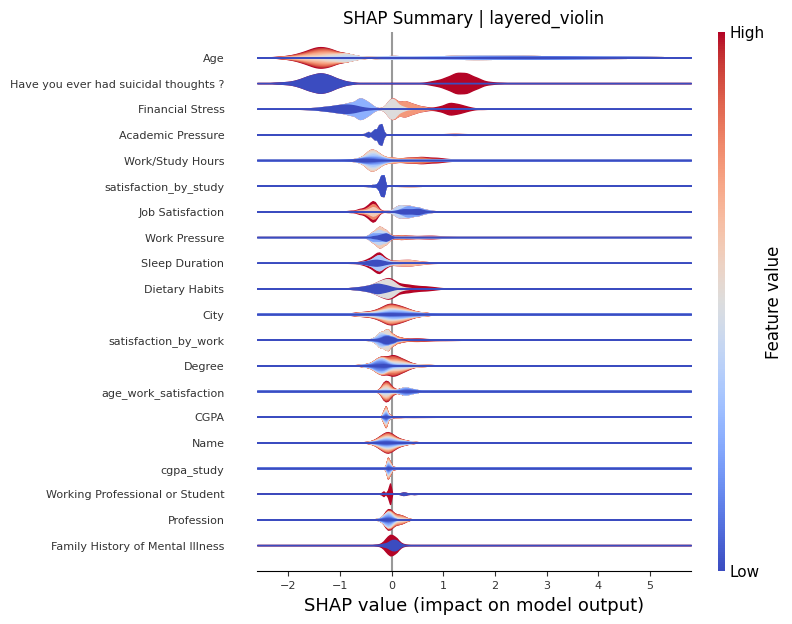

In [46]:
shap.plots.violin(shap_values, plot_type="layered_violin", show = False)
fig, ax = plt.gcf(), plt.gca()
fig.set_figheight(7)
fig.set_figwidth(7)
ax.tick_params(labelsize=8)
ax.set_title("SHAP Summary | layered_violin", fontsize=12)
plt.show()

In [40]:
cat_cv_last = StratifiedKFold(20, shuffle=True, random_state=42)
cat_cv_splits = cat_cv_last.split(X, y)
acc_scores = []
last_test_df_preds = []
X_test_df_pool = Pool(test_df, cat_features=X[obj_feats].columns.values)

In [42]:
for i, (full_train_idx, valid_idx) in enumerate(cat_cv_splits):
    model_fold = CatBoostClassifier(**best_params)
    X_train_fold, X_valid_fold = X.loc[full_train_idx], X.loc[valid_idx]
    y_train_fold, y_valid_fold = y.loc[full_train_idx], y.loc[valid_idx]
    X_train_pool = Pool(X_train_fold, y_train_fold, cat_features=X[obj_feats].columns.values)
    X_valid_pool = Pool(X_valid_fold, y_valid_fold, cat_features=X[obj_feats].columns.values)
    model_fold.fit(X=X_train_pool, eval_set=X_valid_pool, verbose=False, early_stopping_rounds=100)
    valid_pred = model_fold.predict(X_valid_pool)
    score = accuracy_score(y_valid_fold, valid_pred)
    acc_scores.append(score)
    test_df_pred = model_fold.predict_proba(X_test_df_pool)[:, 1]
    last_test_df_preds.append(test_df_pred)
    print(f'Fold {i + 1} Accuracy Score: {score}')

Fold 1 Accuracy Score: 0.9375977256574272
Fold 2 Accuracy Score: 0.9391613361762615
Fold 3 Accuracy Score: 0.9390191897654584
Fold 4 Accuracy Score: 0.9348969438521677
Fold 5 Accuracy Score: 0.9391613361762615
Fold 6 Accuracy Score: 0.9378820184790334
Fold 7 Accuracy Score: 0.9373134328358209
Fold 8 Accuracy Score: 0.938592750533049
Fold 9 Accuracy Score: 0.9402985074626866
Fold 10 Accuracy Score: 0.9366027007818053
Fold 11 Accuracy Score: 0.9411513859275054
Fold 12 Accuracy Score: 0.9411513859275054
Fold 13 Accuracy Score: 0.9388770433546553
Fold 14 Accuracy Score: 0.940724946695096
Fold 15 Accuracy Score: 0.942999289267946
Fold 16 Accuracy Score: 0.9388770433546553
Fold 17 Accuracy Score: 0.938592750533049
Fold 18 Accuracy Score: 0.937455579246624
Fold 19 Accuracy Score: 0.944136460554371


In [61]:
from sklearn.metrics import classification_report
print(classification_report(y_valid_fold, valid_pred))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97      5756
           1       0.85      0.84      0.84      1279

    accuracy                           0.94      7035
   macro avg       0.91      0.90      0.91      7035
weighted avg       0.94      0.94      0.94      7035



In [43]:
sample_submission = pd.read_csv("data/sample_submission.csv")
sample_submission.Depression = np.round(np.mean(last_test_df_preds, axis=0))
sample_submission

id  Depression
0      140700         0.0
1      140701         0.0
2      140702         0.0
3      140703         1.0
4      140704         0.0
...       ...         ...
93795  234495         0.0
93796  234496         1.0
93797  234497         0.0
93798  234498         1.0
93799  234499         0.0

[93800 rows x 2 columns]

In [ ]:
sample_submission.to_csv('data/sample_submission_catboost.csv')